In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

import os
from numpy import genfromtxt
from keras import backend as K
import numpy as np
from keras.layers import Input, Lambda, Conv2D
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Lambda, Flatten, Dense


In [3]:
import os
from collections import defaultdict
import cv2
import numpy as np
import tensorflow

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
# from keras.engine.topology import Layer
from tensorflow.keras import layers
from keras import backend as K
K.set_image_data_format('channels_first')
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
# from inception_block_model.py import imgRecoModel

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [4]:
def get_data_dic(path, train=True):
    dic_data = defaultdict(list)
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        name = str(ID) + '_' + lr + '_' + finger
        dic_data[name].append(os.path.join(path, img))
    return dic_data

In [6]:
altered_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered'
real_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Real'

dic_alt_easy = get_data_dic(altered_path + '-Easy')
dic_alt_hard = get_data_dic(altered_path + '-Hard')
dic_alt_med = get_data_dic(altered_path + '-Medium')
dic_real = get_data_dic(real_path, train=False)

In [7]:
def merge_data(dic1, dic2, dic3):

    for k2, v2 in dic2.items():
        dic1[k2] = dic1[k2] + v2

    for k3, v3 in dic3.items():
        dic1[k3] = dic1[k3] + v3

    return dic1

In [8]:
dic_data = merge_data(dic_alt_easy, dic_alt_hard, dic_alt_med)

In [9]:

dict1 = {key: dic_data[key] for key in list(dic_data.keys())[:5000]}
dict2 = {key: dic_data[key] for key in list(dic_data.keys())[5000:]}

In [10]:
dic_data=dict1

In [11]:
test_dict=dict2

In [12]:
ids = list(test_dict.keys())
len(ids)

1000

In [13]:

def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euc_dist_out_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

def build_network(network, input_shape):
  f_inp = Input(input_shape, name='first_input')
  s_inp = Input(input_shape, name='second_input')

  f_enc = network(f_inp)
  s_enc = network(s_inp)

  output_layer = Lambda(euclidean_distance, output_shape=euc_dist_out_shape)([f_enc, s_enc])
  model = Model(inputs=[f_inp, s_inp], outputs=output_layer)
  return model

In [14]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [15]:
def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )


def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [16]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


1/1 [==============================] - 7s 7s/step


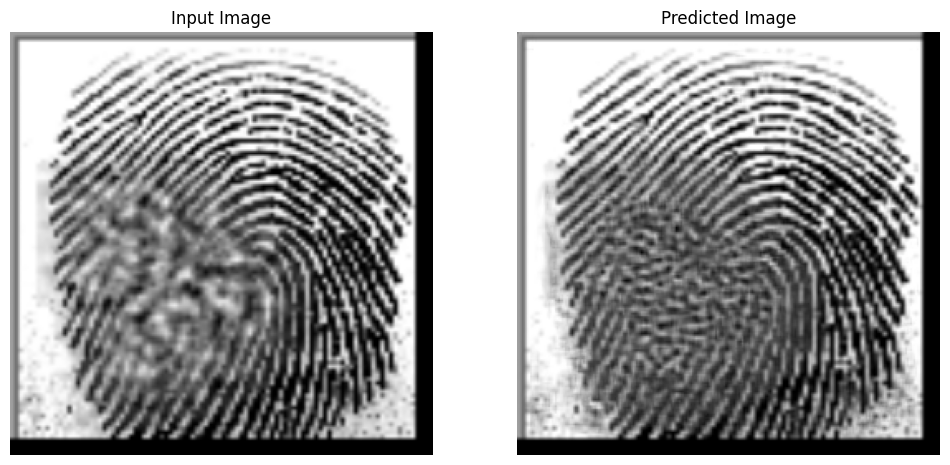

Predicted image saved at: /content/sample_data/predicted_image1.BMP


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
model = load_model('/content/drive/MyDrive/Model/srcnn_model_soco_15k.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/100__M_Left_index_finger_Obl.BMP'  # Replace with the path to your input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (256, 256))
input_image = input_image.astype('float32') / 255.0

# Predict the high-resolution image
input_array = np.expand_dims(input_image, axis=0)
predicted_image = model.predict(input_array)[0]

# Display the input and predicted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Image')
plt.imshow(predicted_image)
plt.axis('off')

plt.show()

# Save the predicted image
output_image_path = '/content/sample_data/predicted_image1.BMP'  # Replace with the desired output path
cv2.imwrite(output_image_path, cv2.cvtColor((predicted_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print("Predicted image saved at:", output_image_path)

In [63]:
real_min_alt_dist_CR=[]
real_min_enhAlt_dist_CR=[]
enhReal_min_enhAlt_dist_CR=[]
real_min_alt_dist_Obl=[]
real_min_enhAlt_dist_Obl=[]
enhReal_min_enhAlt_dist_Obl=[]
real_min_alt_dist_Zcut=[]
real_min_enhAlt_dist_Zcut=[]
enhReal_min_enhAlt_dist_Zcut=[]

In [64]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import Image, display
from PIL import Image

real_min_alt_dist=[]
real_min_enhAlt_dist=[]
enhReal_min_enhAlt_dist=[]

# Load the saved model
model = load_model('/content/drive/MyDrive/Model/srcnn_model_soco_15k.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

# Load another model (assuming you have defined 'p' elsewhere in your code)
p = load_model('/content/drive/MyDrive/Model/model_siamese_git_with_testSplit.h5')




def compute_distance(real_image_path, alt_image_path):
    anc_img_path = real_image_path
    pos_img_path = alt_image_path

    anc_img = np.around(np.transpose(cv2.resize(cv2.imread(anc_img_path), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    pos_img = np.around(np.transpose(cv2.resize(cv2.imread(pos_img_path), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)

    print(pos_img_path)

    if pos_img_path.split('.')[0].endswith('CR'):
       flag = 'CR'
    elif pos_img_path.split('.')[0].endswith('Obl'):
      flag='Obl'
    elif pos_img_path.split('.')[0].endswith('Zcut'):
      flag='Zcut'

    print("flag",flag)

    #neg_img = np.clip(model.predict(np.expand_dims(img_to_array(cv2.imread(pos_img_path)), axis=0)), 0.0, 1.0)[0]

    input_image = cv2.imread(anc_img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (256, 256))
    input_image = input_image.astype('float32') / 255.0

# Convert the input image to a NumPy array
   # input_array = img_to_array(input_image)
    #print(input_array.shape)
# Predict the high-resolution image
    #input_array_transposed = np.transpose(input_array, (1, 2, 0))  # Transpose dimensions
    #print(input_array_transposed.shape)
    input_array=np.expand_dims(input_image, axis=0)
    anc_img1 = model.predict(input_array)[0]

   # Resize the image using the LANCZOS interpolation method
    #anc_img1 = Image.fromarray(np.uint8(input_image * 255))  # Convert NumPy array to Pillow Image
    #neg_img = input_image_pil.resize((desired_width, desired_height), Image.LANCZOS)


# Save the resized image (replace 'output_image_path' with the desired output path)
    output_image_path_anc = '/content/sample_data/predicted_image_anchor.BMP'
    # Ensure values are within the valid range [0, 1]
    anc_img1 = np.clip(anc_img1, 0.0, 1.0)

# Convert the image back to uint8 format (0-255)
    anc_img1 = (anc_img1 * 255).astype(np.uint8)

    cv2.imwrite(output_image_path_anc, anc_img1)
    ''' img = cv2.imread(pos_img_path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.0
    arrayImg=img_to_array(img)
    print(arrayImg)

    neg_img = np.clip(model.predict(arrayImg.reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    print(neg_img.shape)

    plt.imshow(neg_img)'''

    input_image = cv2.imread(pos_img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (256, 256))
    input_image = input_image.astype('float32') / 255.0

# Convert the input image to a NumPy array
    #input_array = img_to_array(input_image)

# Predict the high-resolution image
    #input_array_transposed = np.transpose(input_array, (1, 2, 0))  # Transpose dimensions

    input_array=np.expand_dims(input_image, axis=0)
    neg_img = model.predict(input_array)[0]
   # Resize the image using the LANCZOS interpolation method
    #neg_img = Image.fromarray(np.uint8(input_image * 255))  # Convert NumPy array to Pillow Image
    #neg_img = input_image_pil.resize((desired_width, desired_height), Image.LANCZOS)


# Save the resized image (replace 'output_image_path' with the desired output path)
    output_image_path_neg = '/content/sample_data/predicted_image.BMP'
    neg_img = np.clip(neg_img, 0.0, 1.0)

# Convert the image back to uint8 format (0-255)
    neg_img = (neg_img * 255).astype(np.uint8)
    cv2.imwrite(output_image_path_neg, neg_img)
    # Replace 'image_data' with your image data as a NumPy array
    #image_data = cv2.imread('image.jpg')


   # Convert 'neg_img' to a Pillow Image object
     # Convert 'neg_img' to a NumPy array
    anc_img1 = np.around(np.transpose(cv2.resize(cv2.imread('/content/sample_data/predicted_image_anchor.BMP'), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    neg_img = np.around(np.transpose(cv2.resize(cv2.imread('/content/sample_data/predicted_image.BMP'), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    pos_enc = p.predict_on_batch(np.expand_dims(pos_img, 0))
    anc_enc = p.predict_on_batch(np.expand_dims(anc_img, 0))
    neg_enc = p.predict_on_batch(np.expand_dims(neg_img, 0))
    anc_enc1 = p.predict_on_batch(np.expand_dims(anc_img1, 0))



    print('Distance between real - altered: ', np.linalg.norm(anc_enc - pos_enc))
    real_min_alt_dist.append(np.linalg.norm(anc_enc - pos_enc))
    print('Distance between real - enhanced altered: ', np.linalg.norm(anc_enc - neg_enc))
    real_min_enhAlt_dist.append(np.linalg.norm(anc_enc - neg_enc))
    print('Distance between enhanced real - enhanced altered: ', np.linalg.norm(anc_enc1 - neg_enc))
    enhReal_min_enhAlt_dist.append(np.linalg.norm(anc_enc1 - neg_enc))

    if flag == 'CR':
      real_min_alt_dist_CR.append(np.linalg.norm(anc_enc - pos_enc))
      real_min_enhAlt_dist_CR.append(np.linalg.norm(anc_enc - neg_enc))
      enhReal_min_enhAlt_dist_CR.append(np.linalg.norm(anc_enc1 - neg_enc))
    elif flag == 'Obl':
      real_min_alt_dist_Obl.append(np.linalg.norm(anc_enc - pos_enc))
      real_min_enhAlt_dist_Obl.append(np.linalg.norm(anc_enc - neg_enc))
      enhReal_min_enhAlt_dist_Obl.append(np.linalg.norm(anc_enc1 - neg_enc))
    elif flag=='Zcut':
      real_min_alt_dist_Zcut.append(np.linalg.norm(anc_enc - pos_enc))
      real_min_enhAlt_dist_Zcut.append(np.linalg.norm(anc_enc - neg_enc))
      enhReal_min_enhAlt_dist_Zcut.append(np.linalg.norm(anc_enc1 - neg_enc))
    #print(anc_img.shape)
    #print(pos_img.shape)
    #print(neg_img.shape)

'''    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))
    ax[0].title.set_text('Real Image')
    ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))
    ax[1].title.set_text('Altered Image')
    ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))
    ax[2].title.set_text('Enhanced Altered Image')
    #ax[3].imshow(np.transpose(anc_enc1, (1, 2, 0)))
    #ax[3].title.set_text('Enhanced Real Image')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()'''

"    fig, ax = plt.subplots(1, 3, figsize=(10, 4))\n    ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))\n    ax[0].title.set_text('Real Image')\n    ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))\n    ax[1].title.set_text('Altered Image')\n    ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))\n    ax[2].title.set_text('Enhanced Altered Image')\n    #ax[3].imshow(np.transpose(anc_enc1, (1, 2, 0)))\n    #ax[3].title.set_text('Enhanced Real Image')\n    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])\n    plt.show()"

In [ ]:
len(real_min_alt_dist_CR)

0

In [ ]:
import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

In [19]:
import tensorflow as tf

# Check if a GPU is available and if it's being used by TensorFlow
if tf.test.gpu_device_name():
    print('GPU is available')
    print('GPU device name:', tf.test.gpu_device_name())
else:
    print('GPU is not available')


GPU is not available


In [65]:
#code for matching pairs

from tqdm import tqdm

prefix_to_extract = '/content/drive/MyDrive/SOCOFing/SOCOFing'

# Check if the input string contains the prefix to extract
ids = list(test_dict.keys())

# Create a tqdm instance to track progress
for id in tqdm(ids[:100]):
    input_stringList = test_dict[id]
    for input_string in input_stringList:
        if prefix_to_extract in input_string:
            # Extract the prefix part
            extracted_prefix = input_string.split(prefix_to_extract)[0] + prefix_to_extract

            # Extract the image name
            image_name = input_string.split(prefix_to_extract)[1].split('/')[-1]
            #print(image_name)
            # Remove undesired parts (e.g., "_CR.BMP")
            suffix = "_" + image_name.split('_')[-1]
            #print(suffix)
            if image_name.endswith(suffix):
                result_string = image_name.rstrip(suffix)
                result_string = result_string + '.BMP'
                #print(result_string)

            # Append the suffix to the prefix
            real_image_path = extracted_prefix + '/Real/' + result_string
            alt_image_path = input_string
            compute_distance(real_image_path, alt_image_path)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/216__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.011028714
Distance between real - enhanced altered:  0.29126182
Distance between enhanced real - enhanced altered:  0.00481972
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/216__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0050517977
Distance between real - enhanced altered:  0.2936488
Distance between enhanced real - enhanced altered:  0.0031976474
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/216__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.00046724136
Distance between real - enhanced altered:  0.29163155
Distance between enhanced real - enhanced altered:  0.00041840403
/content/drive/MyDrive/SOCOFin

  1%|          | 1/100 [00:02<03:38,  2.20s/it]

Distance between real - altered:  0.009100908
Distance between real - enhanced altered:  0.29162547
Distance between enhanced real - enhanced altered:  0.0050569377
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0068049943
Distance between real - enhanced altered:  0.5656376
Distance between enhanced real - enhanced altered:  0.0050481525
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0835119
Distance between real - enhanced altered:  0.58940405
Distance between enhanced real - enhanced altered:  0.0937262
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.063

  2%|▏         | 2/100 [00:03<02:51,  1.75s/it]

Distance between real - altered:  0.02249892
Distance between real - enhanced altered:  0.5693679
Distance between enhanced real - enhanced altered:  0.026043683
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0011677342
Distance between real - enhanced altered:  0.084624484
Distance between enhanced real - enhanced altered:  0.0009568498
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.00040250484
Distance between real - enhanced altered:  0.08453352
Distance between enhanced real - enhanced altered:  0.00045257737
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

  3%|▎         | 3/100 [00:04<02:21,  1.46s/it]

Distance between real - altered:  0.001265139
Distance between real - enhanced altered:  0.08447044
Distance between enhanced real - enhanced altered:  0.0014447615
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.009945537
Distance between real - enhanced altered:  0.033090305
Distance between enhanced real - enhanced altered:  0.010441136
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0011835459
Distance between real - enhanced altered:  0.036655273
Distance between enhanced real - enhanced altered:  0.0009529174
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:

  4%|▍         | 4/100 [00:06<02:14,  1.40s/it]

Distance between real - altered:  0.20851801
Distance between real - enhanced altered:  0.33652747
Distance between enhanced real - enhanced altered:  0.308751
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0008624288
Distance between real - enhanced altered:  0.209798
Distance between enhanced real - enhanced altered:  0.00071382854
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.028048001
Distance between real - enhanced altered:  0.222707
Distance between enhanced real - enhanced altered:  0.015128066
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.015186

  5%|▌         | 5/100 [00:07<02:09,  1.36s/it]

Distance between real - altered:  0.00092603924
Distance between real - enhanced altered:  0.21047142
Distance between enhanced real - enhanced altered:  0.0012753492
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0028708633
Distance between real - enhanced altered:  0.315753
Distance between enhanced real - enhanced altered:  0.0013750702
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00019538903
Distance between real - enhanced altered:  0.32135516
Distance between enhanced real - enhanced altered:  0.008611681
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00

  6%|▌         | 6/100 [00:08<01:56,  1.24s/it]

Distance between real - altered:  0.005427918
Distance between real - enhanced altered:  0.31693256
Distance between enhanced real - enhanced altered:  0.0026565248
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0002298474
Distance between real - enhanced altered:  0.19455275
Distance between enhanced real - enhanced altered:  0.0002903264
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.007619324
Distance between real - enhanced altered:  0.1941784
Distance between enhanced real - enhanced altered:  0.0019687917
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0

  7%|▋         | 7/100 [00:09<01:52,  1.21s/it]

Distance between real - altered:  0.04784543
Distance between real - enhanced altered:  0.23608093
Distance between enhanced real - enhanced altered:  0.05315431
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.033194885
Distance between real - enhanced altered:  0.12199607
Distance between enhanced real - enhanced altered:  0.02915103
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 24ms/step
Distance between real - altered:  0.0030866135
Distance between real - enhanced altered:  0.10032707
Distance between enhanced real - enhanced altered:  0.0030797217
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.00

  8%|▊         | 8/100 [00:11<02:12,  1.44s/it]

Distance between real - altered:  0.01756042
Distance between real - enhanced altered:  0.1078001
Distance between enhanced real - enhanced altered:  0.012162595
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0.0052785315
Distance between real - enhanced altered:  0.07937462
Distance between enhanced real - enhanced altered:  0.002871919
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.00023624588
Distance between real - enhanced altered:  0.08237238
Distance between enhanced real - enhanced altered:  0.00034132373
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0

  9%|▉         | 9/100 [00:12<02:10,  1.43s/it]

Distance between real - altered:  0.058870945
Distance between real - enhanced altered:  0.0789059
Distance between enhanced real - enhanced altered:  0.0100626275
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.042582408
Distance between real - enhanced altered:  0.8429763
Distance between enhanced real - enhanced altered:  0.00639697
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.001384845
Distance between real - enhanced altered:  0.8437808
Distance between enhanced real - enhanced altered:  0.0009235904
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.029690627

 10%|█         | 10/100 [00:14<02:01,  1.35s/it]

Distance between real - altered:  0.15399738
Distance between real - enhanced altered:  0.84718865
Distance between enhanced real - enhanced altered:  0.023915682
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.024751386
Distance between real - enhanced altered:  0.046751138
Distance between enhanced real - enhanced altered:  0.007654013
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.022595474
Distance between real - enhanced altered:  0.04327048
Distance between enhanced real - enhanced altered:  0.0039364644
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.

 11%|█         | 11/100 [00:15<01:57,  1.32s/it]

Distance between real - altered:  0.0013435164
Distance between real - enhanced altered:  0.03970519
Distance between enhanced real - enhanced altered:  0.0004327281
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0007661556
Distance between real - enhanced altered:  0.14280634
Distance between enhanced real - enhanced altered:  0.0008577928
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.02243798
Distance between real - enhanced altered:  0.14247681
Distance between enhanced real - enhanced altered:  0.0047896937
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered: 

 12%|█▏        | 12/100 [00:16<01:50,  1.25s/it]

Distance between real - altered:  0.001794634
Distance between real - enhanced altered:  0.14181122
Distance between enhanced real - enhanced altered:  0.0016777577
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0003526304
Distance between real - enhanced altered:  0.28566417
Distance between enhanced real - enhanced altered:  0.00038609453
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.015854996
Distance between real - enhanced altered:  0.2853358
Distance between enhanced real - enhanced altered:  0.0016870637
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altere

 13%|█▎        | 13/100 [00:17<01:45,  1.21s/it]

Distance between real - altered:  0.04900283
Distance between real - enhanced altered:  0.28663024
Distance between enhanced real - enhanced altered:  0.011918452
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.017247852
Distance between real - enhanced altered:  0.08610164
Distance between enhanced real - enhanced altered:  0.012593017
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0036455404
Distance between real - enhanced altered:  0.087583095
Distance between enhanced real - enhanced altered:  0.0035948046
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0

 14%|█▍        | 14/100 [00:18<01:49,  1.28s/it]

Distance between real - altered:  0.063625045
Distance between real - enhanced altered:  0.11543174
Distance between enhanced real - enhanced altered:  0.111405395
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.002964114
Distance between real - enhanced altered:  0.060750347
Distance between enhanced real - enhanced altered:  0.0024242015
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.00017382992
Distance between real - enhanced altered:  0.06254069
Distance between enhanced real - enhanced altered:  0.00047686894
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - alte

 15%|█▌        | 15/100 [00:20<01:52,  1.33s/it]

Distance between real - altered:  0.0068669785
Distance between real - enhanced altered:  0.061394483
Distance between enhanced real - enhanced altered:  0.005434866
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0019653123
Distance between real - enhanced altered:  0.0376948
Distance between enhanced real - enhanced altered:  0.0008071108
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0052572023
Distance between real - enhanced altered:  0.024424965
Distance between enhanced real - enhanced altered:  0.025390439
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

 16%|█▌        | 16/100 [00:21<01:50,  1.32s/it]

Distance between real - altered:  0.0014134366
Distance between real - enhanced altered:  0.038383003
Distance between enhanced real - enhanced altered:  0.000459828
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0008458107
Distance between real - enhanced altered:  0.13010018
Distance between enhanced real - enhanced altered:  0.00047303666
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.024206659
Distance between real - enhanced altered:  0.13410808
Distance between enhanced real - enhanced altered:  0.024929987
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0

 17%|█▋        | 17/100 [00:22<01:44,  1.26s/it]

Distance between real - altered:  0.014651682
Distance between real - enhanced altered:  0.1273513
Distance between enhanced real - enhanced altered:  0.0045385933
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0090066325
Distance between real - enhanced altered:  0.50724137
Distance between enhanced real - enhanced altered:  0.0047194352
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0021573794
Distance between real - enhanced altered:  0.507443
Distance between enhanced real - enhanced altered:  0.00058430637
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0

 18%|█▊        | 18/100 [00:23<01:32,  1.13s/it]

Distance between real - altered:  0.058802534
Distance between real - enhanced altered:  0.43460685
Distance between enhanced real - enhanced altered:  0.089415014
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.035569765
Distance between real - enhanced altered:  0.2064651
Distance between enhanced real - enhanced altered:  0.023545733
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0050983583
Distance between real - enhanced altered:  0.20651652
Distance between enhanced real - enhanced altered:  0.0040086145
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.

 19%|█▉        | 19/100 [00:24<01:23,  1.03s/it]

Distance between real - altered:  0.018157134
Distance between real - enhanced altered:  0.2139424
Distance between enhanced real - enhanced altered:  0.0082636615
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.003513107
Distance between real - enhanced altered:  0.09733527
Distance between enhanced real - enhanced altered:  0.0021560795
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.009210153
Distance between real - enhanced altered:  0.09842674
Distance between enhanced real - enhanced altered:  0.0025958158
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00

 20%|██        | 20/100 [00:25<01:25,  1.07s/it]

Distance between real - altered:  0.01362157
Distance between real - enhanced altered:  0.10011458
Distance between enhanced real - enhanced altered:  0.006898962
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0027017014
Distance between real - enhanced altered:  0.048278585
Distance between enhanced real - enhanced altered:  0.002644042
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00070239144
Distance between real - enhanced altered:  0.04844995
Distance between enhanced real - enhanced altered:  0.00043461632
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

 21%|██        | 21/100 [00:26<01:22,  1.05s/it]

Distance between real - altered:  0.0032647932
Distance between real - enhanced altered:  0.04535481
Distance between enhanced real - enhanced altered:  0.0036417488
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00793016
Distance between real - enhanced altered:  0.09384615
Distance between enhanced real - enhanced altered:  0.0049371715
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0006241805
Distance between real - enhanced altered:  0.09721593
Distance between enhanced real - enhanced altered:  0.0004984944
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.044

 22%|██▏       | 22/100 [00:27<01:15,  1.03it/s]

Distance between real - altered:  0.004913759
Distance between real - enhanced altered:  0.09405043
Distance between enhanced real - enhanced altered:  0.004494014
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.024766862
Distance between real - enhanced altered:  0.067369856
Distance between enhanced real - enhanced altered:  0.0017957955
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.01119865
Distance between real - enhanced altered:  0.06687687
Distance between enhanced real - enhanced altered:  0.0027143145
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00

 23%|██▎       | 23/100 [00:28<01:25,  1.11s/it]

Distance between enhanced real - enhanced altered:  0.002160832
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00097322406
Distance between real - enhanced altered:  0.14966033
Distance between enhanced real - enhanced altered:  0.0010998562
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0017919304
Distance between real - enhanced altered:  0.14612995
Distance between enhanced real - enhanced altered:  0.003706729
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.009589428
Distance between real - enhanced altered:  0.15372486
Distance between enhanced real - 

 24%|██▍       | 24/100 [00:29<01:20,  1.06s/it]

Distance between real - altered:  0.004862245
Distance between real - enhanced altered:  0.15442598
Distance between enhanced real - enhanced altered:  0.0065260464
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.006467244
Distance between real - enhanced altered:  0.16588408
Distance between enhanced real - enhanced altered:  0.0009944503
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.034152634
Distance between real - enhanced altered:  0.16174042
Distance between enhanced real - enhanced altered:  0.018170463
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0

 25%|██▌       | 25/100 [00:31<01:27,  1.17s/it]

Distance between real - altered:  0.012700874
Distance between real - enhanced altered:  0.16351634
Distance between enhanced real - enhanced altered:  0.0060547525
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.017976576
Distance between real - enhanced altered:  0.070402324
Distance between enhanced real - enhanced altered:  0.019837454
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0014766185
Distance between real - enhanced altered:  0.05426541
Distance between enhanced real - enhanced altered:  0.0018036881
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.078289

 26%|██▌       | 26/100 [00:32<01:29,  1.20s/it]

Distance between real - altered:  0.004854671
Distance between real - enhanced altered:  0.052261665
Distance between enhanced real - enhanced altered:  0.0049680644
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.001897515
Distance between real - enhanced altered:  0.06302397
Distance between enhanced real - enhanced altered:  0.0022901087
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0039973394
Distance between real - enhanced altered:  0.062568
Distance between enhanced real - enhanced altered:  0.0022235955
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0004

 27%|██▋       | 27/100 [00:33<01:30,  1.23s/it]

Distance between real - altered:  0.0043064584
Distance between real - enhanced altered:  0.062800996
Distance between enhanced real - enhanced altered:  0.0028372495
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00047393187
Distance between real - enhanced altered:  0.43590024
Distance between enhanced real - enhanced altered:  0.00062803034
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.009923808
Distance between real - enhanced altered:  0.4367183
Distance between enhanced real - enhanced altered:  0.006897339
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  

 28%|██▊       | 28/100 [00:35<01:34,  1.31s/it]

Distance between real - altered:  0.02445689
Distance between real - enhanced altered:  0.44263923
Distance between enhanced real - enhanced altered:  0.008832302
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00040659826
Distance between real - enhanced altered:  0.47773147
Distance between enhanced real - enhanced altered:  0.00066807
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0042667487
Distance between real - enhanced altered:  0.47757164
Distance between enhanced real - enhanced altered:  0.0031790833
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

 29%|██▉       | 29/100 [00:36<01:35,  1.35s/it]

Distance between real - altered:  0.036578294
Distance between real - enhanced altered:  0.4539515
Distance between enhanced real - enhanced altered:  0.07981702
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00031816086
Distance between real - enhanced altered:  0.08490977
Distance between enhanced real - enhanced altered:  0.00022194484
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.014605363
Distance between real - enhanced altered:  0.08571947
Distance between enhanced real - enhanced altered:  0.005969468
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0

 30%|███       | 30/100 [00:37<01:31,  1.31s/it]

Distance between real - altered:  0.0020162056
Distance between real - enhanced altered:  0.084532246
Distance between enhanced real - enhanced altered:  0.0048051155
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00059881445
Distance between real - enhanced altered:  0.11245906
Distance between enhanced real - enhanced altered:  0.0004970814
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0075226384
Distance between real - enhanced altered:  0.115991294
Distance between enhanced real - enhanced altered:  0.007145827
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

 31%|███       | 31/100 [00:39<01:35,  1.38s/it]

Distance between real - altered:  0.009228895
Distance between real - enhanced altered:  0.10841113
Distance between enhanced real - enhanced altered:  0.004327884
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00016837493
Distance between real - enhanced altered:  0.04128034
Distance between enhanced real - enhanced altered:  0.00014433968
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0.005370667
Distance between real - enhanced altered:  0.041312642
Distance between enhanced real - enhanced altered:  0.0010464586
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  

 32%|███▏      | 32/100 [00:40<01:34,  1.39s/it]

Distance between real - altered:  0.0052464865
Distance between real - enhanced altered:  0.040404122
Distance between enhanced real - enhanced altered:  0.0023423631
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0018232231
Distance between real - enhanced altered:  0.051469713
Distance between enhanced real - enhanced altered:  0.0015393115
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.09467996
Distance between real - enhanced altered:  0.13270515
Distance between enhanced real - enhanced altered:  0.1544626
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0

 33%|███▎      | 33/100 [00:42<01:41,  1.51s/it]

Distance between real - altered:  0.0031899896
Distance between real - enhanced altered:  0.05066178
Distance between enhanced real - enhanced altered:  0.0034812957
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0028219097
Distance between real - enhanced altered:  0.05460521
Distance between enhanced real - enhanced altered:  0.0024332257
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0005255243
Distance between real - enhanced altered:  0.05397199
Distance between enhanced real - enhanced altered:  0.0005153206
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 34%|███▍      | 34/100 [00:44<01:40,  1.53s/it]

Distance between real - altered:  0.0040798807
Distance between real - enhanced altered:  0.055500038
Distance between enhanced real - enhanced altered:  0.003925154
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0062942347
Distance between real - enhanced altered:  0.5589978
Distance between enhanced real - enhanced altered:  0.007150915
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0008978715
Distance between real - enhanced altered:  0.5537987
Distance between enhanced real - enhanced altered:  0.0011378117
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 35%|███▌      | 35/100 [00:45<01:40,  1.54s/it]

Distance between real - altered:  0.0037777172
Distance between real - enhanced altered:  0.5467228
Distance between enhanced real - enhanced altered:  0.017372027
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.013625705
Distance between real - enhanced altered:  0.080680005
Distance between enhanced real - enhanced altered:  0.01115915
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0012439702
Distance between real - enhanced altered:  0.07138986
Distance between enhanced real - enhanced altered:  0.0011710749
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0

 36%|███▌      | 36/100 [00:47<01:35,  1.50s/it]

Distance between real - altered:  0.0024449227
Distance between real - enhanced altered:  0.07158405
Distance between enhanced real - enhanced altered:  0.0008474265
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0047549405
Distance between real - enhanced altered:  0.3048314
Distance between enhanced real - enhanced altered:  0.0038965326
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.022074688
Distance between real - enhanced altered:  0.3397496
Distance between enhanced real - enhanced altered:  0.057968315
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0

 37%|███▋      | 37/100 [00:48<01:35,  1.52s/it]

Distance between real - altered:  0.20234512
Distance between real - enhanced altered:  0.39408296
Distance between enhanced real - enhanced altered:  0.1956173
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.026069952
Distance between real - enhanced altered:  0.07936011
Distance between enhanced real - enhanced altered:  0.0044919006
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0041239513
Distance between real - enhanced altered:  0.081884466
Distance between enhanced real - enhanced altered:  0.005796528
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 24ms/step
Distance between real - altered:  

 38%|███▊      | 38/100 [00:50<01:33,  1.51s/it]

Distance between real - altered:  0.02638576
Distance between real - enhanced altered:  0.09945693
Distance between enhanced real - enhanced altered:  0.020413313
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0010382453
Distance between real - enhanced altered:  0.061694458
Distance between enhanced real - enhanced altered:  0.0006710495
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0028969583
Distance between real - enhanced altered:  0.06422813
Distance between enhanced real - enhanced altered:  0.0042478973
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered: 

 39%|███▉      | 39/100 [00:51<01:27,  1.44s/it]

Distance between real - altered:  0.0023028906
Distance between real - enhanced altered:  0.062506385
Distance between enhanced real - enhanced altered:  0.0015852404
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.009110232
Distance between real - enhanced altered:  0.7372559
Distance between enhanced real - enhanced altered:  0.0044167372
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0013115309
Distance between real - enhanced altered:  0.734867
Distance between enhanced real - enhanced altered:  0.001165218
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0

 40%|████      | 40/100 [00:52<01:25,  1.43s/it]

Distance between real - altered:  0.00921647
Distance between real - enhanced altered:  0.7389252
Distance between enhanced real - enhanced altered:  0.008014981
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0049116835
Distance between real - enhanced altered:  0.0915759
Distance between enhanced real - enhanced altered:  0.0026204707
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0021382533
Distance between real - enhanced altered:  0.09177808
Distance between enhanced real - enhanced altered:  0.00069292047
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

 41%|████      | 41/100 [00:54<01:24,  1.43s/it]

Distance between real - altered:  0.0049526035
Distance between real - enhanced altered:  0.09108893
Distance between enhanced real - enhanced altered:  0.003050797
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.002422884
Distance between real - enhanced altered:  0.30142775
Distance between enhanced real - enhanced altered:  0.00126915
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.07828058
Distance between real - enhanced altered:  0.32795653
Distance between enhanced real - enhanced altered:  0.09672295
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.

 42%|████▏     | 42/100 [00:55<01:23,  1.45s/it]

Distance between real - altered:  0.007364699
Distance between real - enhanced altered:  0.30299923
Distance between enhanced real - enhanced altered:  0.006494803
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0064722067
Distance between real - enhanced altered:  0.07332399
Distance between enhanced real - enhanced altered:  0.013041586
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00027418646
Distance between real - enhanced altered:  0.074817315
Distance between enhanced real - enhanced altered:  0.00032266972
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 43%|████▎     | 43/100 [00:57<01:23,  1.47s/it]

Distance between real - altered:  0.0024263556
Distance between real - enhanced altered:  0.07408261
Distance between enhanced real - enhanced altered:  0.004299393
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.016051363
Distance between real - enhanced altered:  0.10821653
Distance between enhanced real - enhanced altered:  0.006521679
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.02685849
Distance between real - enhanced altered:  0.1143424
Distance between enhanced real - enhanced altered:  0.014050342
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00055

 44%|████▍     | 44/100 [00:58<01:20,  1.44s/it]

Distance between real - altered:  0.0024925258
Distance between real - enhanced altered:  0.10590779
Distance between enhanced real - enhanced altered:  0.0018921909
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0058208713
Distance between real - enhanced altered:  0.05938999
Distance between enhanced real - enhanced altered:  0.009974192
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00013962264
Distance between real - enhanced altered:  0.050849445
Distance between enhanced real - enhanced altered:  0.00015004212
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0

 45%|████▌     | 45/100 [01:00<01:19,  1.45s/it]

Distance between real - altered:  0.006808839
Distance between real - enhanced altered:  0.057781436
Distance between enhanced real - enhanced altered:  0.008335387
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00019720467
Distance between real - enhanced altered:  0.22364576
Distance between enhanced real - enhanced altered:  0.00023683513
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.020317255
Distance between real - enhanced altered:  0.21730208
Distance between enhanced real - enhanced altered:  0.018152267
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0

 46%|████▌     | 46/100 [01:01<01:17,  1.44s/it]

Distance between real - altered:  0.055619337
Distance between real - enhanced altered:  0.18143965
Distance between enhanced real - enhanced altered:  0.04579792
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.10551552
Distance between real - enhanced altered:  0.06487422
Distance between enhanced real - enhanced altered:  0.017365202
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.021751052
Distance between real - enhanced altered:  0.049239326
Distance between enhanced real - enhanced altered:  0.012025523
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.00

 47%|████▋     | 47/100 [01:03<01:16,  1.45s/it]

Distance between real - altered:  0.0049118046
Distance between real - enhanced altered:  0.05430837
Distance between enhanced real - enhanced altered:  0.0074221184
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.002681576
Distance between real - enhanced altered:  0.033061314
Distance between enhanced real - enhanced altered:  0.0016336741
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.008852088
Distance between real - enhanced altered:  0.03479499
Distance between enhanced real - enhanced altered:  0.004966897
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered: 

 48%|████▊     | 48/100 [01:04<01:14,  1.44s/it]

Distance between real - altered:  0.071109824
Distance between real - enhanced altered:  0.12352404
Distance between enhanced real - enhanced altered:  0.122495815
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0047384812
Distance between real - enhanced altered:  0.15142588
Distance between enhanced real - enhanced altered:  0.0054301964
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0015139829
Distance between real - enhanced altered:  0.15345877
Distance between enhanced real - enhanced altered:  0.0016669908
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.

 49%|████▉     | 49/100 [01:05<01:12,  1.43s/it]

Distance between real - altered:  0.040842865
Distance between real - enhanced altered:  0.16413544
Distance between enhanced real - enhanced altered:  0.04317661
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0004122734
Distance between real - enhanced altered:  0.71167547
Distance between enhanced real - enhanced altered:  0.000706
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.002819744
Distance between real - enhanced altered:  0.7133393
Distance between enhanced real - enhanced altered:  0.0029479507
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0138094

 50%|█████     | 50/100 [01:07<01:11,  1.44s/it]

Distance between real - altered:  0.02121019
Distance between real - enhanced altered:  0.7138196
Distance between enhanced real - enhanced altered:  0.039566312
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0013444513
Distance between real - enhanced altered:  0.103144884
Distance between enhanced real - enhanced altered:  0.0026355577
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0009057275
Distance between real - enhanced altered:  0.102479644
Distance between enhanced real - enhanced altered:  0.00034668893
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - alter

 51%|█████     | 51/100 [01:08<01:10,  1.43s/it]

Distance between real - altered:  0.0009107668
Distance between real - enhanced altered:  0.10192015
Distance between enhanced real - enhanced altered:  0.000825846
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0005196378
Distance between real - enhanced altered:  0.43270662
Distance between enhanced real - enhanced altered:  0.0005887489
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.017773965
Distance between real - enhanced altered:  0.43324646
Distance between enhanced real - enhanced altered:  0.009829647
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0

 52%|█████▏    | 52/100 [01:10<01:10,  1.48s/it]

Distance between real - altered:  0.013102243
Distance between real - enhanced altered:  0.43231928
Distance between enhanced real - enhanced altered:  0.012719377
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.30491966
Distance between real - enhanced altered:  0.30481508
Distance between enhanced real - enhanced altered:  0.22863694
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.11293831
Distance between real - enhanced altered:  0.545809
Distance between enhanced real - enhanced altered:  0.089281134
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.002093

 53%|█████▎    | 53/100 [01:11<01:10,  1.50s/it]

Distance between real - altered:  0.01672157
Distance between real - enhanced altered:  0.48624423
Distance between enhanced real - enhanced altered:  0.008252705
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0008792765
Distance between real - enhanced altered:  0.3287899
Distance between enhanced real - enhanced altered:  0.0011172475
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0047426857
Distance between real - enhanced altered:  0.32772544
Distance between enhanced real - enhanced altered:  0.0032452007
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.08

 54%|█████▍    | 54/100 [01:13<01:08,  1.49s/it]

Distance between real - altered:  0.003405877
Distance between real - enhanced altered:  0.32927895
Distance between enhanced real - enhanced altered:  0.0028039007
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.009181692
Distance between real - enhanced altered:  0.7834375
Distance between enhanced real - enhanced altered:  0.007274244
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0013475103
Distance between real - enhanced altered:  0.779244
Distance between enhanced real - enhanced altered:  0.0011023558
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0

 55%|█████▌    | 55/100 [01:14<01:07,  1.49s/it]

Distance between real - altered:  0.0060130083
Distance between real - enhanced altered:  0.77995527
Distance between enhanced real - enhanced altered:  0.002293905
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.002031396
Distance between real - enhanced altered:  0.32984513
Distance between enhanced real - enhanced altered:  0.0013287177
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00033114708
Distance between real - enhanced altered:  0.3294946
Distance between enhanced real - enhanced altered:  0.0026759987
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered: 

 56%|█████▌    | 56/100 [01:16<01:02,  1.43s/it]

Distance between real - altered:  0.0027216729
Distance between real - enhanced altered:  0.32946527
Distance between enhanced real - enhanced altered:  0.003231921
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.016339794
Distance between real - enhanced altered:  0.5722007
Distance between enhanced real - enhanced altered:  0.0026612845
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.012682635
Distance between real - enhanced altered:  0.5709074
Distance between enhanced real - enhanced altered:  0.009298044
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  

 57%|█████▋    | 57/100 [01:17<01:01,  1.42s/it]

Distance between real - altered:  0.015715072
Distance between real - enhanced altered:  0.58351004
Distance between enhanced real - enhanced altered:  0.019329578
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.001045048
Distance between real - enhanced altered:  0.26761836
Distance between enhanced real - enhanced altered:  0.0013878137
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0017399653
Distance between real - enhanced altered:  0.2686863
Distance between enhanced real - enhanced altered:  0.002206434
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.011237

 58%|█████▊    | 58/100 [01:19<01:00,  1.43s/it]

Distance between real - altered:  0.0043565854
Distance between real - enhanced altered:  0.2739516
Distance between enhanced real - enhanced altered:  0.010442022
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.042203333
Distance between real - enhanced altered:  0.63479894
Distance between enhanced real - enhanced altered:  0.037514783
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.033169128
Distance between real - enhanced altered:  0.6487982
Distance between enhanced real - enhanced altered:  0.046809457
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0

 59%|█████▉    | 59/100 [01:20<00:58,  1.43s/it]

Distance between real - altered:  0.004463378
Distance between real - enhanced altered:  0.65558386
Distance between enhanced real - enhanced altered:  0.0016354803
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00522611
Distance between real - enhanced altered:  0.24001104
Distance between enhanced real - enhanced altered:  0.005419961
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0002119454
Distance between real - enhanced altered:  0.24180475
Distance between enhanced real - enhanced altered:  0.00020812901
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0

 60%|██████    | 60/100 [01:21<00:57,  1.43s/it]

Distance between real - altered:  0.002053211
Distance between real - enhanced altered:  0.24155676
Distance between enhanced real - enhanced altered:  0.0016004194
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.030782264
Distance between real - enhanced altered:  0.2898341
Distance between enhanced real - enhanced altered:  0.023117064
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.004585596
Distance between real - enhanced altered:  0.2660602
Distance between enhanced real - enhanced altered:  0.011279675
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00

 61%|██████    | 61/100 [01:23<00:56,  1.44s/it]

Distance between real - altered:  0.037429247
Distance between real - enhanced altered:  0.29558548
Distance between enhanced real - enhanced altered:  0.05712108
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0012854815
Distance between real - enhanced altered:  0.58844846
Distance between enhanced real - enhanced altered:  0.00039652755
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0035636064
Distance between real - enhanced altered:  0.5887513
Distance between enhanced real - enhanced altered:  0.0016077651
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  

 62%|██████▏   | 62/100 [01:24<00:54,  1.43s/it]

Distance between real - altered:  0.042066198
Distance between real - enhanced altered:  0.72907084
Distance between enhanced real - enhanced altered:  0.23260699
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0031213074
Distance between real - enhanced altered:  0.14691079
Distance between enhanced real - enhanced altered:  0.003176915
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0038692793
Distance between real - enhanced altered:  0.1487394
Distance between enhanced real - enhanced altered:  0.0029445407
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered: 

 63%|██████▎   | 63/100 [01:25<00:45,  1.24s/it]

Distance between real - altered:  0.008307533
Distance between real - enhanced altered:  0.14824906
Distance between enhanced real - enhanced altered:  0.0015148609
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.013474253
Distance between real - enhanced altered:  0.10107168
Distance between enhanced real - enhanced altered:  0.019778762
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00019777035
Distance between real - enhanced altered:  0.09732243
Distance between enhanced real - enhanced altered:  0.00030323403
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0

 64%|██████▍   | 64/100 [01:27<00:46,  1.30s/it]

Distance between real - altered:  0.0022927907
Distance between real - enhanced altered:  0.09663464
Distance between enhanced real - enhanced altered:  0.0013377166
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0001267219
Distance between real - enhanced altered:  0.07363904
Distance between enhanced real - enhanced altered:  0.0002678415
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.032902077
Distance between real - enhanced altered:  0.0792061
Distance between enhanced real - enhanced altered:  0.065077424
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0

 65%|██████▌   | 65/100 [01:28<00:51,  1.47s/it]

Distance between real - altered:  0.00091355067
Distance between real - enhanced altered:  0.073579244
Distance between enhanced real - enhanced altered:  0.0006602935
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 26ms/step
Distance between real - altered:  0.0006989437
Distance between real - enhanced altered:  0.03363431
Distance between enhanced real - enhanced altered:  0.00055068056
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 26ms/step
Distance between real - altered:  0.015224872
Distance between real - enhanced altered:  0.034811728
Distance between enhanced real - enhanced altered:  0.0061807684
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 25ms/step
Distance between real - alte

 66%|██████▌   | 66/100 [01:30<00:50,  1.49s/it]

Distance between real - altered:  0.0028623221
Distance between real - enhanced altered:  0.03546913
Distance between enhanced real - enhanced altered:  0.0047088866
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0.0077654575
Distance between real - enhanced altered:  0.09139361
Distance between enhanced real - enhanced altered:  0.0011435037
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.002345328
Distance between real - enhanced altered:  0.094832554
Distance between enhanced real - enhanced altered:  0.011737122
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0

 67%|██████▋   | 67/100 [01:32<00:50,  1.54s/it]

Distance between real - altered:  0.015442168
Distance between real - enhanced altered:  0.07493991
Distance between enhanced real - enhanced altered:  0.037091073
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.011510493
Distance between real - enhanced altered:  0.024002314
Distance between enhanced real - enhanced altered:  0.004408698
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.0019782009
Distance between real - enhanced altered:  0.027284486
Distance between enhanced real - enhanced altered:  0.000602411
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.0

 68%|██████▊   | 68/100 [01:33<00:46,  1.45s/it]

Distance between real - altered:  0.0035783686
Distance between real - enhanced altered:  0.024208931
Distance between enhanced real - enhanced altered:  0.0037941586
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.06979839
Distance between real - enhanced altered:  0.16801296
Distance between enhanced real - enhanced altered:  0.05853752
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0013047761
Distance between real - enhanced altered:  0.13541481
Distance between enhanced real - enhanced altered:  0.0012225752
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  

 69%|██████▉   | 69/100 [01:34<00:44,  1.42s/it]

Distance between real - altered:  0.0352723
Distance between real - enhanced altered:  0.17074272
Distance between enhanced real - enhanced altered:  0.038584907
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00046703703
Distance between real - enhanced altered:  0.11176818
Distance between enhanced real - enhanced altered:  0.00033610905
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0010369887
Distance between real - enhanced altered:  0.110971235
Distance between enhanced real - enhanced altered:  0.0011647489
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00

 70%|███████   | 70/100 [01:36<00:43,  1.45s/it]

Distance between real - altered:  0.15783864
Distance between real - enhanced altered:  0.16689637
Distance between enhanced real - enhanced altered:  0.079184674
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.000716185
Distance between real - enhanced altered:  0.051052187
Distance between enhanced real - enhanced altered:  0.00103361
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.04106676
Distance between real - enhanced altered:  0.055257667
Distance between enhanced real - enhanced altered:  0.025557224
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.22

 71%|███████   | 71/100 [01:37<00:40,  1.40s/it]

Distance between real - altered:  0.37655145
Distance between real - enhanced altered:  0.19558685
Distance between enhanced real - enhanced altered:  0.21100836
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.091304205
Distance between real - enhanced altered:  0.06433027
Distance between enhanced real - enhanced altered:  0.03246381
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0012089524
Distance between real - enhanced altered:  0.031995963
Distance between enhanced real - enhanced altered:  0.00088479085
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.

 72%|███████▏  | 72/100 [01:38<00:38,  1.37s/it]

Distance between real - altered:  0.0014974719
Distance between real - enhanced altered:  0.03332638
Distance between enhanced real - enhanced altered:  0.003094041
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0007942634
Distance between real - enhanced altered:  0.051492516
Distance between enhanced real - enhanced altered:  0.00072990934
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.016889801
Distance between real - enhanced altered:  0.054693926
Distance between enhanced real - enhanced altered:  0.007574411
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - alte

 73%|███████▎  | 73/100 [01:40<00:36,  1.35s/it]

Distance between real - altered:  0.13943985
Distance between real - enhanced altered:  0.09268796
Distance between enhanced real - enhanced altered:  0.044545833
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.03478293
Distance between real - enhanced altered:  0.14629468
Distance between enhanced real - enhanced altered:  0.018373743
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0029585066
Distance between real - enhanced altered:  0.13616724
Distance between enhanced real - enhanced altered:  0.0011566284
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 74%|███████▍  | 74/100 [01:41<00:35,  1.37s/it]

Distance between real - altered:  0.0040337965
Distance between real - enhanced altered:  0.13567372
Distance between enhanced real - enhanced altered:  0.004011729
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.00044432245
Distance between real - enhanced altered:  0.046328392
Distance between enhanced real - enhanced altered:  0.00014244112
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0014521813
Distance between real - enhanced altered:  0.0463776
Distance between enhanced real - enhanced altered:  0.0017531032
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altere

 75%|███████▌  | 75/100 [01:42<00:32,  1.29s/it]

Distance between real - altered:  0.0018165866
Distance between real - enhanced altered:  0.046558592
Distance between enhanced real - enhanced altered:  0.0015766106
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.11605149
Distance between real - enhanced altered:  0.17134303
Distance between enhanced real - enhanced altered:  0.14094116
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0041975067
Distance between real - enhanced altered:  0.1272921
Distance between enhanced real - enhanced altered:  0.0040088203
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00

 76%|███████▌  | 76/100 [01:44<00:32,  1.34s/it]

Distance between real - altered:  0.00096135045
Distance between real - enhanced altered:  0.12502185
Distance between enhanced real - enhanced altered:  0.0012582123
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.007031209
Distance between real - enhanced altered:  0.08274932
Distance between enhanced real - enhanced altered:  0.0014275744
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00022488758
Distance between real - enhanced altered:  0.08357432
Distance between enhanced real - enhanced altered:  0.00027864298
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0

 77%|███████▋  | 77/100 [01:45<00:31,  1.37s/it]

Distance between real - altered:  0.023666186
Distance between real - enhanced altered:  0.08800302
Distance between enhanced real - enhanced altered:  0.008791186
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0031631142
Distance between real - enhanced altered:  0.11868105
Distance between enhanced real - enhanced altered:  0.0028045224
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0015378104
Distance between real - enhanced altered:  0.11754847
Distance between enhanced real - enhanced altered:  0.0008651024
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.

 78%|███████▊  | 78/100 [01:46<00:30,  1.41s/it]

Distance between real - altered:  0.0024888401
Distance between real - enhanced altered:  0.116932794
Distance between enhanced real - enhanced altered:  0.0014188465
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.04702748
Distance between real - enhanced altered:  0.112263426
Distance between enhanced real - enhanced altered:  0.0208485
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0013322715
Distance between real - enhanced altered:  0.095910996
Distance between enhanced real - enhanced altered:  0.0022040203
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered: 

 79%|███████▉  | 79/100 [01:48<00:29,  1.40s/it]

Distance between real - altered:  0.0072393073
Distance between real - enhanced altered:  0.093120284
Distance between enhanced real - enhanced altered:  0.0070096715
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.010729728
Distance between real - enhanced altered:  0.065714665
Distance between enhanced real - enhanced altered:  0.010804271
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0011866221
Distance between real - enhanced altered:  0.06354583
Distance between enhanced real - enhanced altered:  0.0011347923
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - alte

 80%|████████  | 80/100 [01:49<00:27,  1.37s/it]

Distance between real - altered:  0.06677346
Distance between real - enhanced altered:  0.06822773
Distance between enhanced real - enhanced altered:  0.053803444
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00079905626
Distance between real - enhanced altered:  0.04592199
Distance between enhanced real - enhanced altered:  0.001138719
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.039799586
Distance between real - enhanced altered:  0.06465412
Distance between enhanced real - enhanced altered:  0.023150759
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.

 81%|████████  | 81/100 [01:50<00:24,  1.30s/it]

Distance between real - altered:  0.013828057
Distance between real - enhanced altered:  0.041025702
Distance between enhanced real - enhanced altered:  0.012465352
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.06533969
Distance between real - enhanced altered:  0.42433116
Distance between enhanced real - enhanced altered:  0.37608802
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00028925567
Distance between real - enhanced altered:  0.16598305
Distance between enhanced real - enhanced altered:  0.0006423006
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.05

 82%|████████▏ | 82/100 [01:52<00:24,  1.34s/it]

Distance between real - altered:  0.017478136
Distance between real - enhanced altered:  0.16669925
Distance between enhanced real - enhanced altered:  0.011264026
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.004970411
Distance between real - enhanced altered:  0.07493221
Distance between enhanced real - enhanced altered:  0.0038341386
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0016271289
Distance between real - enhanced altered:  0.07725769
Distance between enhanced real - enhanced altered:  0.0013403323
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered

 83%|████████▎ | 83/100 [01:53<00:19,  1.17s/it]

Distance between real - altered:  0.06517549
Distance between real - enhanced altered:  0.045303654
Distance between enhanced real - enhanced altered:  0.04826012
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.002640217
Distance between real - enhanced altered:  0.32554865
Distance between enhanced real - enhanced altered:  0.0038019747
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.02452103
Distance between real - enhanced altered:  0.32235786
Distance between enhanced real - enhanced altered:  0.012873969
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.05

 84%|████████▍ | 84/100 [01:53<00:16,  1.06s/it]

Distance between real - altered:  0.11499565
Distance between real - enhanced altered:  0.3126735
Distance between enhanced real - enhanced altered:  0.05251061
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.2343629
Distance between real - enhanced altered:  0.6032493
Distance between enhanced real - enhanced altered:  0.16310456
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0014621221
Distance between real - enhanced altered:  0.45474172
Distance between enhanced real - enhanced altered:  0.0010707426
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.016404

 85%|████████▌ | 85/100 [01:55<00:16,  1.12s/it]

Distance between real - altered:  0.016382769
Distance between real - enhanced altered:  0.4669326
Distance between enhanced real - enhanced altered:  0.015261002
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.045117605
Distance between real - enhanced altered:  0.19915242
Distance between enhanced real - enhanced altered:  0.022650668
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.05961923
Distance between real - enhanced altered:  0.17387281
Distance between enhanced real - enhanced altered:  0.015872689
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.002

 86%|████████▌ | 86/100 [01:56<00:16,  1.21s/it]

Distance between real - altered:  0.013507212
Distance between real - enhanced altered:  0.18025178
Distance between enhanced real - enhanced altered:  0.026079096
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00057388813
Distance between real - enhanced altered:  0.05921715
Distance between enhanced real - enhanced altered:  0.00033371605
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.109183565
Distance between real - enhanced altered:  0.16313903
Distance between enhanced real - enhanced altered:  0.18755844
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered

 87%|████████▋ | 87/100 [01:57<00:16,  1.28s/it]

Distance between real - altered:  0.0045757378
Distance between real - enhanced altered:  0.05718136
Distance between enhanced real - enhanced altered:  0.0042716768
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.051860735
Distance between real - enhanced altered:  0.09316585
Distance between enhanced real - enhanced altered:  0.038390297
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0016584632
Distance between real - enhanced altered:  0.056691736
Distance between enhanced real - enhanced altered:  0.001165391
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.001

 88%|████████▊ | 88/100 [01:59<00:14,  1.23s/it]

Distance between real - altered:  0.012267259
Distance between real - enhanced altered:  0.058368415
Distance between enhanced real - enhanced altered:  0.004811387
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  9.276852e-05
Distance between real - enhanced altered:  0.04277513
Distance between enhanced real - enhanced altered:  7.41505e-05
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0008510852
Distance between real - enhanced altered:  0.04269122
Distance between enhanced real - enhanced altered:  0.0004991084
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.

 89%|████████▉ | 89/100 [02:00<00:14,  1.32s/it]

Distance between real - altered:  0.007574002
Distance between real - enhanced altered:  0.03986384
Distance between enhanced real - enhanced altered:  0.0055046566
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.053666756
Distance between real - enhanced altered:  0.10375098
Distance between enhanced real - enhanced altered:  0.033954162
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.008679969
Distance between real - enhanced altered:  0.10648095
Distance between enhanced real - enhanced altered:  0.004359517
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered: 

 90%|█████████ | 90/100 [02:01<00:11,  1.18s/it]

Distance between real - altered:  0.041452877
Distance between real - enhanced altered:  0.12634891
Distance between enhanced real - enhanced altered:  0.04874273
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00055967795
Distance between real - enhanced altered:  0.23566137
Distance between enhanced real - enhanced altered:  0.00075975
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0046681934
Distance between real - enhanced altered:  0.23595366
Distance between enhanced real - enhanced altered:  0.0016950455
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0

 91%|█████████ | 91/100 [02:02<00:11,  1.28s/it]

Distance between real - altered:  0.0024151267
Distance between real - enhanced altered:  0.2353578
Distance between enhanced real - enhanced altered:  0.002469971
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0001613801
Distance between real - enhanced altered:  0.06255107
Distance between enhanced real - enhanced altered:  3.75868e-05
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0019669952
Distance between real - enhanced altered:  0.06257386
Distance between enhanced real - enhanced altered:  0.00036865228
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.

 92%|█████████▏| 92/100 [02:04<00:10,  1.35s/it]

Distance between real - altered:  0.006563642
Distance between real - enhanced altered:  0.06366256
Distance between enhanced real - enhanced altered:  0.001967317
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.022417432
Distance between real - enhanced altered:  0.058733314
Distance between enhanced real - enhanced altered:  0.017338874
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0050290474
Distance between real - enhanced altered:  0.042174608
Distance between enhanced real - enhanced altered:  0.0029553026
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.

 93%|█████████▎| 93/100 [02:05<00:09,  1.33s/it]

Distance between real - altered:  0.013377195
Distance between real - enhanced altered:  0.04710752
Distance between enhanced real - enhanced altered:  0.018264616
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.022187006
Distance between real - enhanced altered:  0.32457206
Distance between enhanced real - enhanced altered:  0.0031175513
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.00036396558
Distance between real - enhanced altered:  0.3240988
Distance between enhanced real - enhanced altered:  0.00051141594
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.005

 94%|█████████▍| 94/100 [02:06<00:07,  1.31s/it]

Distance between real - altered:  0.26832402
Distance between real - enhanced altered:  0.799017
Distance between enhanced real - enhanced altered:  0.76691437
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00349121
Distance between real - enhanced altered:  0.13997199
Distance between enhanced real - enhanced altered:  0.0014035146
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.04937488
Distance between real - enhanced altered:  0.2252031
Distance between enhanced real - enhanced altered:  0.1746709
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.000129145

 95%|█████████▌| 95/100 [02:08<00:06,  1.29s/it]

Distance between real - altered:  0.0020488955
Distance between real - enhanced altered:  0.14096859
Distance between enhanced real - enhanced altered:  0.00090024446
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.42529988
Distance between real - enhanced altered:  0.3224863
Distance between enhanced real - enhanced altered:  0.055665124
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.046449017
Distance between real - enhanced altered:  0.30916822
Distance between enhanced real - enhanced altered:  0.010438034
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.004

 96%|█████████▌| 96/100 [02:09<00:05,  1.33s/it]

Distance between real - altered:  0.027668154
Distance between real - enhanced altered:  0.31111795
Distance between enhanced real - enhanced altered:  0.00366986
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.13876174
Distance between real - enhanced altered:  0.15210927
Distance between enhanced real - enhanced altered:  0.07861138
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0025875017
Distance between real - enhanced altered:  0.15033777
Distance between enhanced real - enhanced altered:  0.00425173
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0008

 97%|█████████▋| 97/100 [02:10<00:03,  1.26s/it]

Distance between real - altered:  0.0021390414
Distance between real - enhanced altered:  0.15188901
Distance between enhanced real - enhanced altered:  0.0020622842
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0678433
Distance between real - enhanced altered:  0.2205997
Distance between enhanced real - enhanced altered:  0.069506064
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.021859491
Distance between real - enhanced altered:  0.18954031
Distance between enhanced real - enhanced altered:  0.011204484
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.00039

 98%|█████████▊| 98/100 [02:11<00:02,  1.12s/it]

Distance between real - altered:  0.08693705
Distance between real - enhanced altered:  0.23485908
Distance between enhanced real - enhanced altered:  0.08693549
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.036387373
Distance between real - enhanced altered:  0.40961307
Distance between enhanced real - enhanced altered:  0.008953811
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.004784941
Distance between real - enhanced altered:  0.4082052
Distance between enhanced real - enhanced altered:  0.0051060277
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.

 99%|█████████▉| 99/100 [02:13<00:01,  1.22s/it]

Distance between real - altered:  0.011567321
Distance between real - enhanced altered:  0.4179665
Distance between enhanced real - enhanced altered:  0.025027836
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0010558093
Distance between real - enhanced altered:  0.023934193
Distance between enhanced real - enhanced altered:  0.0006720012
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0009844602
Distance between real - enhanced altered:  0.023704588
Distance between enhanced real - enhanced altered:  0.0011008492
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - alter

100%|██████████| 100/100 [02:14<00:00,  1.34s/it]

Distance between real - altered:  0.0013146617
Distance between real - enhanced altered:  0.02501962
Distance between enhanced real - enhanced altered:  0.0014105381


In [ ]:
print(len(real_min_alt_dist_CR))
print(len(real_min_enhAlt_dist))
print(len(enhReal_min_enhAlt_dist))


2719
8166
8166


In [ ]:
# Define your Python list
my_list = enhReal_min_enhAlt_dist_Zcut

# Specify the file path where you want to save the list
file_path = "enhReal_min_enhAlt_dist_Zcut.txt"

# Open the file in write mode and write the list elements to it
with open(file_path, "w") as file:
    for item in my_list:
        file.write(str(item) + "\n")

print("List saved to", file_path)


List saved to enhReal_min_enhAlt_dist_Zcut.txt


In [66]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(real_min_alt_dist_CR)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)


In [ ]:
len(real_min_alt_dist_CR)

2719

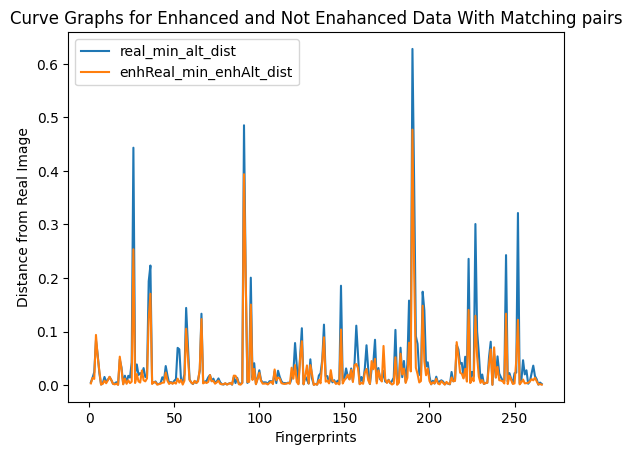

In [67]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_CR
#y2_data = real_min_enhAlt_dist[:100]
y3_data = enhReal_min_enhAlt_dist_CR

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Not Enahanced Data With Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()


In [95]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(real_min_alt_dist_CR)+1
for dist1,dist2 in zip(real_min_alt_dist_CR,enhReal_min_enhAlt_dist_CR):
  if dist1>=dist2:
    positive_count+=1

  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for matching pairs {negative_percent}")

218
48
postive_percent for matching pairs 81.64794007490637
negative_percent for matching pairs 17.97752808988764


In [69]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(real_min_alt_dist_Obl)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

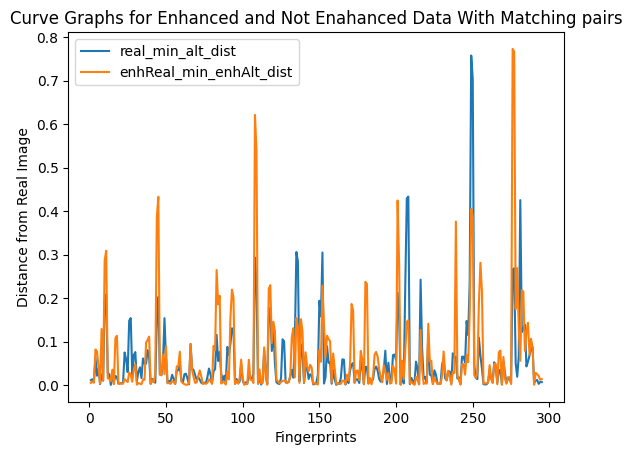

In [70]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_Obl
#y2_data = real_min_enhAlt_dist[:100]
y3_data = enhReal_min_enhAlt_dist_Obl

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Not Enahanced Data With Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [96]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(real_min_alt_dist_Obl)
for dist1,dist2 in zip(real_min_alt_dist_Obl,enhReal_min_enhAlt_dist_Obl):
  if dist1>=dist2:
    positive_count+=1

  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for matching pairs {negative_percent}")

148
147
postive_percent for matching pairs 50.16949152542372
negative_percent for matching pairs 49.83050847457628


In [72]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(real_min_alt_dist_Zcut)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

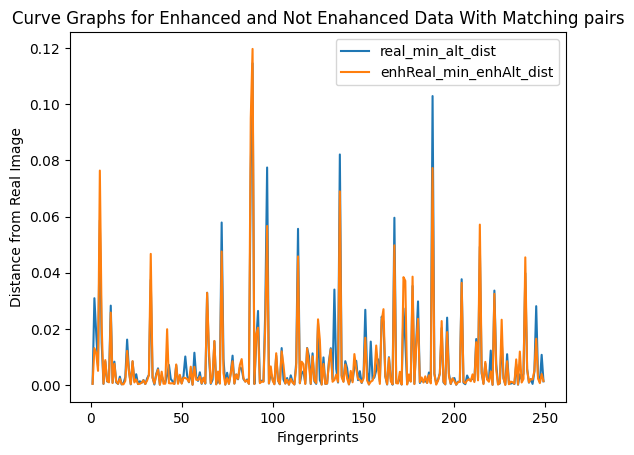

In [73]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_Zcut
#y2_data = real_min_enhAlt_dist[:100]
y3_data = enhReal_min_enhAlt_dist_Zcut

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Not Enahanced Data With Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [97]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(real_min_alt_dist_Zcut)
for dist1,dist2 in zip(real_min_alt_dist_Zcut,enhReal_min_enhAlt_dist_Zcut):
  if dist1>=dist2:
    positive_count+=1

  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for matching pairs {negative_percent}")

149
100
postive_percent for matching pairs 59.83935742971887
negative_percent for matching pairs 40.16064257028113


In [52]:
#code for non-matching pairs
import random
from tqdm import tqdm

prefix_to_extract = '/content/drive/MyDrive/SOCOFing/SOCOFing'

# Check if the input string contains the prefix to extract
ids = list(test_dict.keys())

# Create a tqdm instance to track progress
for id in tqdm(ids[:100]):
    input_stringList = test_dict[id]
    for input_string in input_stringList:
        if prefix_to_extract in input_string:
            # Extract the prefix part
            extracted_prefix = input_string.split(prefix_to_extract)[0] + prefix_to_extract

            # Extract the image name
            image_name = input_string.split(prefix_to_extract)[1].split('/')[-1]
            #print(image_name)
            # Remove undesired parts (e.g., "_CR.BMP")
            suffix = "_" + image_name.split('_')[-1]
            #print(suffix)
            if image_name.endswith(suffix):
                result_string = image_name.rstrip(suffix)
                result_string = result_string + '.BMP'
                #print(result_string)

            # Append the suffix to the prefix
            real_image_path = extracted_prefix + '/Real/' + result_string
            alt_image_path=input_string
            while alt_image_path==input_string:
              randomId=random.choice(ids)
              randomIdLength= len(test_dict[randomId])
              random_number = random.randint(0, randomIdLength-1)
              alt_image_path = test_dict[randomId][random_number]
              print("real_image_path", real_image_path)
              print("alt_image_path",alt_image_path)
            compute_distance(real_image_path, alt_image_path)

  0%|          | 0/100 [00:00<?, ?it/s]

real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/216__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/189__F_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/189__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2356371
Distance between real - enhanced altered:  1.2137755
Distance between enhanced real - enhanced altered:  1.0798677
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/216__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/148__M_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/148__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.5366974
Distance between real - enhanced altered:  1.5380243
Distance between enha

  1%|          | 1/100 [00:08<14:15,  8.64s/it]

Distance between real - altered:  1.3970954
Distance between real - enhanced altered:  1.2626786
Distance between enhanced real - enhanced altered:  1.3343945
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/217__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/149__F_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/149__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.3526592
Distance between real - enhanced altered:  1.3739803
Distance between enhanced real - enhanced altered:  1.4817132
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/217__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/169__F_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/169__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==========

  2%|▏         | 2/100 [00:16<13:39,  8.36s/it]

Distance between real - altered:  1.7669086
Distance between real - enhanced altered:  1.8495243
Distance between enhanced real - enhanced altered:  1.873778
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/217__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/12__M_Left_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/12__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.9806258
Distance between real - enhanced altered:  1.0002656
Distance between enhanced real - enhanced altered:  1.0538023
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/217__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/111__M_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/111__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============

  3%|▎         | 3/100 [00:23<12:32,  7.75s/it]

Distance between real - altered:  0.7633673
Distance between real - enhanced altered:  0.80574745
Distance between enhanced real - enhanced altered:  0.74697334
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/217__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/107__M_Right_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/107__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2932061
Distance between real - enhanced altered:  1.2996452
Distance between enhanced real - enhanced altered:  1.2890275
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/217__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/178__M_Left_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/178__M_Left_middle_finger_CR.BMP
flag CR
1/1 [=

  4%|▍         | 4/100 [00:29<11:17,  7.06s/it]

Distance between real - altered:  1.6072671
Distance between real - enhanced altered:  1.5856779
Distance between enhanced real - enhanced altered:  1.5890507
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/128__M_Right_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/128__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.569248
Distance between real - enhanced altered:  0.70599526
Distance between enhanced real - enhanced altered:  0.61864567
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/168__M_Left_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/168__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [===============

  5%|▌         | 5/100 [00:36<11:01,  6.97s/it]

Distance between real - altered:  0.9045409
Distance between real - enhanced altered:  0.8708711
Distance between enhanced real - enhanced altered:  1.0102499
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/124__M_Right_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/124__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.44485116
Distance between real - enhanced altered:  0.47929794
Distance between enhanced real - enhanced altered:  0.24555413
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Left_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Left_little_finger_Obl.BMP
flag Obl
1/

  6%|▌         | 6/100 [00:41<09:53,  6.31s/it]

Distance between real - altered:  0.8459405
Distance between real - enhanced altered:  0.7156098
Distance between enhanced real - enhanced altered:  0.73851126
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/11__M_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/11__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6910818
Distance between real - enhanced altered:  1.7401519
Distance between enhanced real - enhanced altered:  1.7097079
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/177__F_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/177__F_Right_little_finger_CR.BMP
flag CR
1/1 [=====

  7%|▋         | 7/100 [00:47<09:24,  6.07s/it]

Distance between real - altered:  0.7528725
Distance between real - enhanced altered:  0.78389543
Distance between enhanced real - enhanced altered:  0.7425442
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/150__M_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/150__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.3604407
Distance between real - enhanced altered:  1.3465142
Distance between enhanced real - enhanced altered:  1.3294166
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/154__F_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/154__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [===

  8%|▊         | 8/100 [00:54<10:01,  6.54s/it]

Distance between real - altered:  1.3120201
Distance between real - enhanced altered:  1.3410026
Distance between enhanced real - enhanced altered:  1.3384094
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/183__M_Right_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/183__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 24ms/step
Distance between real - altered:  0.7748266
Distance between real - enhanced altered:  0.60022265
Distance between enhanced real - enhanced altered:  0.5866548
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/141__F_Left_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/141__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============

  9%|▉         | 9/100 [00:59<08:56,  5.90s/it]

Distance between real - altered:  1.1862555
Distance between real - enhanced altered:  1.1740046
Distance between enhanced real - enhanced altered:  1.2037826
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/118__F_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/118__F_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.9092819
Distance between real - enhanced altered:  0.9169616
Distance between enhanced real - enhanced altered:  1.3693316
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/151__M_Left_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/151__M_Left_index_finger_CR.BMP
flag CR
1/1 [=============

 10%|█         | 10/100 [01:04<08:32,  5.70s/it]

Distance between real - altered:  1.0942847
Distance between real - enhanced altered:  1.1083398
Distance between enhanced real - enhanced altered:  1.4957304
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/187__M_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/187__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2603097
Distance between real - enhanced altered:  1.2392608
Distance between enhanced real - enhanced altered:  1.2167912
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/12__M_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/12__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==========

 11%|█         | 11/100 [01:10<08:36,  5.80s/it]

Distance between real - altered:  0.80740225
Distance between real - enhanced altered:  0.8862849
Distance between enhanced real - enhanced altered:  0.8926043
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/106__M_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/106__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6131449
Distance between real - enhanced altered:  1.5967846
Distance between enhanced real - enhanced altered:  1.5957334
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/16__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/16__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [===

 12%|█▏        | 12/100 [01:16<08:25,  5.74s/it]

Distance between real - altered:  1.0357049
Distance between real - enhanced altered:  1.1049014
Distance between enhanced real - enhanced altered:  1.082317
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/146__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/146__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.1443744
Distance between real - enhanced altered:  1.198764
Distance between enhanced real - enhanced altered:  1.2818713
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/179__M_Right_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/179__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [=========

 13%|█▎        | 13/100 [01:22<08:42,  6.00s/it]

Distance between real - altered:  1.1663302
Distance between real - enhanced altered:  1.1905247
Distance between enhanced real - enhanced altered:  1.1436741
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3619134
Distance between real - enhanced altered:  1.365492
Distance between enhanced real - enhanced altered:  1.3537236
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/145__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/145__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [===

 14%|█▍        | 14/100 [01:30<09:33,  6.67s/it]

Distance between real - altered:  1.4899219
Distance between real - enhanced altered:  1.4850441
Distance between enhanced real - enhanced altered:  1.4660364
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.3459164
Distance between real - enhanced altered:  1.4489608
Distance between enhanced real - enhanced altered:  1.462289
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/150__M_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/150__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [=========

 15%|█▌        | 15/100 [01:36<08:51,  6.25s/it]

Distance between real - altered:  1.223833
Distance between real - enhanced altered:  1.2077101
Distance between enhanced real - enhanced altered:  1.2380383
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/150__M_Left_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/150__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.72913396
Distance between real - enhanced altered:  0.7785732
Distance between enhanced real - enhanced altered:  0.75231487
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/138__M_Right_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/138__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [======

 16%|█▌        | 16/100 [01:41<08:21,  5.97s/it]

Distance between real - altered:  1.4244777
Distance between real - enhanced altered:  1.4338387
Distance between enhanced real - enhanced altered:  1.4279138
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/172__M_Left_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/172__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.392499
Distance between real - enhanced altered:  1.3901079
Distance between enhanced real - enhanced altered:  1.409751
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/16__M_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/16__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [=============

 17%|█▋        | 17/100 [01:47<08:20,  6.04s/it]

Distance between real - altered:  1.3894138
Distance between real - enhanced altered:  1.404181
Distance between enhanced real - enhanced altered:  1.3793902
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/126__F_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/126__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.424235
Distance between real - enhanced altered:  1.3439456
Distance between enhanced real - enhanced altered:  1.3555602
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/218__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/182__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/182__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [=============

 18%|█▊        | 18/100 [01:52<07:31,  5.50s/it]

Distance between real - altered:  1.5448629
Distance between real - enhanced altered:  1.5113508
Distance between enhanced real - enhanced altered:  1.5938444
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/188__M_Right_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/188__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.8630036
Distance between real - enhanced altered:  1.8302672
Distance between enhanced real - enhanced altered:  1.8269497
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/219__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/218__M_Left_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/218__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [=====

 19%|█▉        | 19/100 [01:53<05:45,  4.27s/it]

Distance between real - altered:  1.010746
Distance between real - enhanced altered:  1.0227443
Distance between enhanced real - enhanced altered:  1.1478667
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/187__M_Right_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/187__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.099165
Distance between real - enhanced altered:  1.1089814
Distance between enhanced real - enhanced altered:  1.0514671
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/14__M_Left_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/14__M_Left_ring_finger_CR.BMP
flag CR
1/1 [=============

 20%|██        | 20/100 [01:58<06:00,  4.51s/it]

0.6034976
Distance between enhanced real - enhanced altered:  0.5306054
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/159__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/158__M_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/158__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1113691
Distance between real - enhanced altered:  1.0968201
Distance between enhanced real - enhanced altered:  1.1176695
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/159__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/138__M_Left_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/138__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.58744013
Distance

 21%|██        | 21/100 [02:02<05:41,  4.33s/it]

Distance between real - altered:  1.1769385
Distance between real - enhanced altered:  1.1214675
Distance between enhanced real - enhanced altered:  1.1280792
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/122__M_Right_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/122__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.6131346
Distance between real - enhanced altered:  0.6604447
Distance between enhanced real - enhanced altered:  0.588445
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/114__F_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/114__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [=============

 22%|██▏       | 22/100 [02:06<05:37,  4.33s/it]

Distance between real - altered:  0.9815642
Distance between real - enhanced altered:  0.9749732
Distance between enhanced real - enhanced altered:  1.0225246
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/130__F_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/130__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.2341022
Distance between real - enhanced altered:  1.2864637
Distance between enhanced real - enhanced altered:  1.2800215
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/136__F_Right_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/136__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [=======

 23%|██▎       | 23/100 [02:14<06:55,  5.40s/it]

Distance between real - altered:  1.5926135
Distance between real - enhanced altered:  1.6414683
Distance between enhanced real - enhanced altered:  1.6541852
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/141__F_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/141__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.858191
Distance between real - enhanced altered:  0.8573845
Distance between enhanced real - enhanced altered:  0.8056946
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/146__M_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/146__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [====

 24%|██▍       | 24/100 [02:19<06:49,  5.38s/it]

Distance between real - altered:  1.0257689
Distance between real - enhanced altered:  1.1038891
Distance between enhanced real - enhanced altered:  1.0313363
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/134__M_Right_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/134__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.6197171
Distance between real - enhanced altered:  0.64190865
Distance between enhanced real - enhanced altered:  0.6599979
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/183__M_Right_thumb_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/183__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [

 25%|██▌       | 25/100 [02:28<07:45,  6.21s/it]

Distance between real - altered:  1.4720055
Distance between real - enhanced altered:  1.4670975
Distance between enhanced real - enhanced altered:  1.4779716
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/122__M_Right_thumb_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/122__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5994611
Distance between real - enhanced altered:  1.6562991
Distance between enhanced real - enhanced altered:  1.6707036
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/11__M_Left_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/11__M_Left_middle_finger_CR.BMP
flag CR
1/1 [=================

 26%|██▌       | 26/100 [02:34<07:43,  6.26s/it]

Distance between real - altered:  0.804354
Distance between real - enhanced altered:  0.84986013
Distance between enhanced real - enhanced altered:  0.887443
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/184__M_Right_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/184__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.4303435
Distance between real - enhanced altered:  0.2843306
Distance between enhanced real - enhanced altered:  0.33449453
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/118__F_Left_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/118__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [=======

 27%|██▋       | 27/100 [02:42<08:05,  6.65s/it]

Distance between real - altered:  1.3987465
Distance between real - enhanced altered:  1.3949805
Distance between enhanced real - enhanced altered:  1.3639045
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/108__M_Left_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/108__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.48909
Distance between real - enhanced altered:  1.4817338
Distance between enhanced real - enhanced altered:  1.615953
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [========

 28%|██▊       | 28/100 [02:48<07:48,  6.51s/it]

real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/159__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/157__M_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/157__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2137237
Distance between real - enhanced altered:  1.2199512
Distance between enhanced real - enhanced altered:  0.94039065
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/159__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2029289
Distance between real - enhanced altered:  1.1984122
Distance bet

 29%|██▉       | 29/100 [02:55<07:48,  6.60s/it]

Distance between real - altered:  1.6149004
Distance between real - enhanced altered:  1.579009
Distance between enhanced real - enhanced altered:  1.4307035
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/164__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/164__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.6112203
Distance between real - enhanced altered:  0.6698689
Distance between enhanced real - enhanced altered:  0.659495
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Right_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Right_ring_finger_CR.BMP
flag CR
1/1 [============

 30%|███       | 30/100 [02:59<07:06,  6.09s/it]

Distance between real - altered:  0.51946324
Distance between real - enhanced altered:  0.60939467
Distance between enhanced real - enhanced altered:  0.5905076
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/176__M_Left_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/176__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.6496888
Distance between real - enhanced altered:  1.6493372
Distance between enhanced real - enhanced altered:  1.6427808
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/129__M_Left_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/129__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [=======

 31%|███       | 31/100 [03:06<07:17,  6.33s/it]

Distance between real - altered:  0.56874496
Distance between real - enhanced altered:  0.71193624
Distance between enhanced real - enhanced altered:  0.6959009
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/159__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/171__M_Right_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/171__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0292296
Distance between real - enhanced altered:  1.0679518
Distance between enhanced real - enhanced altered:  1.0845463
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/159__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/127__F_Left_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/127__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [============

 32%|███▏      | 32/100 [03:11<06:35,  5.82s/it]

Distance between real - altered:  1.4164824
Distance between real - enhanced altered:  1.4138821
Distance between enhanced real - enhanced altered:  1.4195304
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/151__M_Left_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/151__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.0944297
Distance between real - enhanced altered:  1.1646354
Distance between enhanced real - enhanced altered:  1.1714174
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/132__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/132__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [========

 33%|███▎      | 33/100 [03:18<06:56,  6.21s/it]

Distance between real - altered:  1.5937947
Distance between real - enhanced altered:  1.6274563
Distance between enhanced real - enhanced altered:  1.625355
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/107__M_Right_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/107__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.0088214
Distance between real - enhanced altered:  1.0178399
Distance between enhanced real - enhanced altered:  0.9801756
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/15__F_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/14__M_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/14__M_Right_middle_finger_CR.BMP
flag CR
1/1 [====================

 34%|███▍      | 34/100 [03:26<07:28,  6.80s/it]

Distance between real - altered:  1.470872
Distance between real - enhanced altered:  1.4893205
Distance between enhanced real - enhanced altered:  1.48815
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/181__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/181__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.7134914
Distance between real - enhanced altered:  1.7273972
Distance between enhanced real - enhanced altered:  1.5526227
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/103__F_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/103__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [============

 35%|███▌      | 35/100 [03:32<07:03,  6.51s/it]

Distance between real - altered:  1.5551809
Distance between real - enhanced altered:  1.6267424
Distance between enhanced real - enhanced altered:  1.4475594
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/176__M_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/176__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.8027703
Distance between real - enhanced altered:  1.7343194
Distance between enhanced real - enhanced altered:  1.7332579
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/170__M_Left_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/170__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [=====

 36%|███▌      | 36/100 [03:39<07:07,  6.68s/it]

Distance between real - altered:  1.4826922
Distance between real - enhanced altered:  1.4881736
Distance between enhanced real - enhanced altered:  1.4718874
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/158__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/158__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.731461
Distance between real - enhanced altered:  0.7541698
Distance between enhanced real - enhanced altered:  0.99626297
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/134__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/134__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [=====

 37%|███▋      | 37/100 [03:45<06:40,  6.36s/it]

Distance between real - altered:  1.5464348
Distance between real - enhanced altered:  1.5508862
Distance between enhanced real - enhanced altered:  1.5930533
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/124__M_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/124__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.5695791
Distance between real - enhanced altered:  1.5643301
Distance between enhanced real - enhanced altered:  1.5625957
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/189__F_Right_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/189__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [

 38%|███▊      | 38/100 [03:52<06:43,  6.51s/it]

Distance between real - altered:  1.5958223
Distance between real - enhanced altered:  1.6017182
Distance between enhanced real - enhanced altered:  1.6177126
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/179__M_Right_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/179__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.67098117
Distance between real - enhanced altered:  0.5478922
Distance between enhanced real - enhanced altered:  0.59318846
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/182__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/182__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [======

 39%|███▉      | 39/100 [03:58<06:34,  6.46s/it]

Distance between real - altered:  1.1051308
Distance between real - enhanced altered:  1.0641739
Distance between enhanced real - enhanced altered:  1.0834978
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/144__M_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/144__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4493705
Distance between real - enhanced altered:  1.3432158
Distance between enhanced real - enhanced altered:  1.2593964
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/131__M_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/131__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [=========

 40%|████      | 40/100 [04:05<06:34,  6.57s/it]

Distance between real - altered:  0.24515706
Distance between real - enhanced altered:  0.9652614
Distance between enhanced real - enhanced altered:  0.33181116
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/173__F_Left_thumb_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/173__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6598505
Distance between real - enhanced altered:  1.6482284
Distance between enhanced real - enhanced altered:  1.6615407
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/14__M_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/14__M_Right_middle_finger_CR.BMP
flag CR
1/1 [=======

 41%|████      | 41/100 [04:11<06:28,  6.58s/it]

Distance between real - altered:  1.4246835
Distance between real - enhanced altered:  1.4545593
Distance between enhanced real - enhanced altered:  1.5021942
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/170__M_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/170__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.7417816
Distance between real - enhanced altered:  0.78326446
Distance between enhanced real - enhanced altered:  0.55223745
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/157__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/157__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [===

 42%|████▏     | 42/100 [04:19<06:40,  6.91s/it]

Distance between real - altered:  1.5897195
Distance between real - enhanced altered:  1.5767843
Distance between enhanced real - enhanced altered:  1.5890625
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.830374
Distance between real - enhanced altered:  0.8313372
Distance between enhanced real - enhanced altered:  0.8732832
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Left_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Left_index_finger_CR.BMP
flag CR
1/1 [================

 43%|████▎     | 43/100 [04:26<06:26,  6.78s/it]

Distance between real - altered:  0.5606381
Distance between real - enhanced altered:  0.53194934
Distance between enhanced real - enhanced altered:  0.57575244
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/169__F_Left_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/169__F_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.3537745
Distance between real - enhanced altered:  1.3293177
Distance between enhanced real - enhanced altered:  1.3247943
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/152__M_Right_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/152__M_Right_index_finger_Zcut.BMP
flag Zcut


 44%|████▍     | 44/100 [04:33<06:29,  6.95s/it]

Distance between real - altered:  1.3841429
Distance between real - enhanced altered:  1.3649026
Distance between enhanced real - enhanced altered:  1.3736576
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/168__M_Left_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/168__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4877639
Distance between real - enhanced altered:  1.4652234
Distance between enhanced real - enhanced altered:  1.4670765
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/11__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/11__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [========

 45%|████▌     | 45/100 [04:40<06:19,  6.90s/it]

Distance between real - altered:  1.0306247
Distance between real - enhanced altered:  0.7401153
Distance between enhanced real - enhanced altered:  0.70181334
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.8590354
Distance between real - enhanced altered:  0.9064124
Distance between enhanced real - enhanced altered:  1.0859997
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/165__M_Left_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/165__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [===============

 46%|████▌     | 46/100 [04:46<06:04,  6.76s/it]

Distance between real - altered:  1.1699122
Distance between real - enhanced altered:  1.265792
Distance between enhanced real - enhanced altered:  1.3487183
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/172__M_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/172__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.8875351
Distance between real - enhanced altered:  1.2972356
Distance between enhanced real - enhanced altered:  1.2712669
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/168__M_Right_thumb_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/168__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==

 47%|████▋     | 47/100 [04:52<05:36,  6.34s/it]

Distance between real - altered:  1.2849051
Distance between real - enhanced altered:  1.3027132
Distance between enhanced real - enhanced altered:  1.323046
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/117__F_Left_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/117__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.086746
Distance between real - enhanced altered:  1.1259315
Distance between enhanced real - enhanced altered:  1.1267225
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/108__M_Left_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/108__M_Left_index_finger_CR.BMP
flag CR
1/1 [=============

 48%|████▊     | 48/100 [04:58<05:39,  6.52s/it]

Distance between real - altered:  1.5022671
Distance between real - enhanced altered:  1.5255574
Distance between enhanced real - enhanced altered:  1.531198
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/150__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/150__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.4490565
Distance between real - enhanced altered:  1.4660367
Distance between enhanced real - enhanced altered:  1.472331
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/160__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/17__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/17__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [===================

 49%|████▉     | 49/100 [05:04<05:21,  6.30s/it]

Distance between real - altered:  0.90691113
Distance between real - enhanced altered:  0.96861017
Distance between enhanced real - enhanced altered:  1.0249077
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/119__F_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/119__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4575094
Distance between real - enhanced altered:  1.4706534
Distance between enhanced real - enhanced altered:  1.415888
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/134__M_Right_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/134__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==

 50%|█████     | 50/100 [05:13<05:47,  6.95s/it]

Distance between real - altered:  1.5528132
Distance between real - enhanced altered:  1.5697378
Distance between enhanced real - enhanced altered:  1.5235906
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/115__F_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/115__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.174872
Distance between real - enhanced altered:  0.9552731
Distance between enhanced real - enhanced altered:  0.9544453
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/141__F_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/141__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [=====

 51%|█████     | 51/100 [05:20<05:45,  7.05s/it]

Distance between real - altered:  1.3257083
Distance between real - enhanced altered:  1.3283435
Distance between enhanced real - enhanced altered:  1.2992419
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/152__M_Right_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/152__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.7544401
Distance between real - enhanced altered:  0.794711
Distance between enhanced real - enhanced altered:  0.83154404
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [====

 52%|█████▏    | 52/100 [05:27<05:44,  7.17s/it]

Distance between real - altered:  0.84409857
Distance between real - enhanced altered:  0.83214825
Distance between enhanced real - enhanced altered:  1.0884521
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/133__M_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/133__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.89197737
Distance between real - enhanced altered:  1.0410374
Distance between enhanced real - enhanced altered:  0.7149621
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/13__F_Left_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/13__F_Left_middle_finger_CR.BMP
flag CR
1/1 [====

 53%|█████▎    | 53/100 [05:34<05:29,  7.01s/it]

Distance between real - altered:  1.2625786
Distance between real - enhanced altered:  1.3075646
Distance between enhanced real - enhanced altered:  1.109622
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/174__F_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/174__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2065033
Distance between real - enhanced altered:  1.1447266
Distance between enhanced real - enhanced altered:  1.0987011
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/152__M_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/152__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============

 54%|█████▍    | 54/100 [05:42<05:35,  7.30s/it]

Distance between real - altered:  0.44140998
Distance between real - enhanced altered:  0.5020024
Distance between enhanced real - enhanced altered:  0.3567328
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/12__M_Right_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/12__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2845263
Distance between real - enhanced altered:  1.2580605
Distance between enhanced real - enhanced altered:  0.79375124
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/218__M_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/218__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [=======

 55%|█████▌    | 55/100 [05:48<05:12,  6.94s/it]

Distance between real - altered:  1.5729802
Distance between real - enhanced altered:  1.551781
Distance between enhanced real - enhanced altered:  1.7019913
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.9753799
Distance between real - enhanced altered:  1.118487
Distance between enhanced real - enhanced altered:  1.0608346
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/180__F_Left_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/180__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [================

 56%|█████▌    | 56/100 [05:54<04:49,  6.59s/it]

Distance between real - altered:  0.9689649
Distance between real - enhanced altered:  0.994281
Distance between enhanced real - enhanced altered:  0.82405406
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/165__M_Left_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/165__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.1291845
Distance between real - enhanced altered:  1.0558558
Distance between enhanced real - enhanced altered:  1.3054922
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/114__F_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/114__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [========

 57%|█████▋    | 57/100 [06:01<04:49,  6.74s/it]

Distance between real - altered:  1.2388557
Distance between real - enhanced altered:  1.236626
Distance between enhanced real - enhanced altered:  1.4245752
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/125__M_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/125__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.39400333
Distance between real - enhanced altered:  0.29921666
Distance between enhanced real - enhanced altered:  0.45541817
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/135__F_Left_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/135__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [===========

 58%|█████▊    | 58/100 [06:10<05:10,  7.38s/it]

Distance between real - altered:  1.3893367
Distance between real - enhanced altered:  1.3645775
Distance between enhanced real - enhanced altered:  1.3533444
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/162__M_Left_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/162__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.477521
Distance between real - enhanced altered:  1.4178107
Distance between enhanced real - enhanced altered:  1.232912
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/161__F_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/109__F_Right_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/109__F_Right_ring_finger_CR.BMP
flag CR
1/1 [=================

 59%|█████▉    | 59/100 [06:17<04:57,  7.25s/it]

Distance between real - altered:  1.8366734
Distance between real - enhanced altered:  1.8189813
Distance between enhanced real - enhanced altered:  1.7004633
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/157__M_Left_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/157__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.81046736
Distance between real - enhanced altered:  0.7927956
Distance between enhanced real - enhanced altered:  0.90896803
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/133__M_Right_ring_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/133__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [===========

 60%|██████    | 60/100 [06:24<04:44,  7.11s/it]

Distance between real - altered:  0.8537286
Distance between real - enhanced altered:  0.8754248
Distance between enhanced real - enhanced altered:  0.87804145
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/182__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/182__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.894616
Distance between real - enhanced altered:  0.93176544
Distance between enhanced real - enhanced altered:  0.7079908
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/119__F_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/119__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [=====

 61%|██████    | 61/100 [06:32<04:46,  7.35s/it]

Distance between real - altered:  0.7501477
Distance between real - enhanced altered:  0.7243382
Distance between enhanced real - enhanced altered:  0.7890314
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/137__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/137__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.6491061
Distance between real - enhanced altered:  1.6399755
Distance between enhanced real - enhanced altered:  1.7101204
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/162__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/143__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/143__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [=====

 62%|██████▏   | 62/100 [06:38<04:29,  7.10s/it]

Distance between real - altered:  1.3877462
Distance between real - enhanced altered:  1.4795375
Distance between enhanced real - enhanced altered:  1.3226621
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/175__M_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/175__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.1028436
Distance between real - enhanced altered:  1.1278821
Distance between enhanced real - enhanced altered:  1.140693
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/185__M_Right_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/185__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [=====

 63%|██████▎   | 63/100 [06:42<03:47,  6.16s/it]

Distance between real - altered:  0.7999728
Distance between real - enhanced altered:  0.81300294
Distance between enhanced real - enhanced altered:  0.9016773
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/17__M_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/17__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.6007836
Distance between real - enhanced altered:  0.68893707
Distance between enhanced real - enhanced altered:  0.6262826
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [=====

 64%|██████▍   | 64/100 [06:48<03:42,  6.17s/it]

Distance between real - altered:  1.5556287
Distance between real - enhanced altered:  1.578126
Distance between enhanced real - enhanced altered:  1.5856729
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/147__M_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/147__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.70699424
Distance between real - enhanced altered:  0.716686
Distance between enhanced real - enhanced altered:  0.75726944
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/148__M_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/148__M_Right_little_finger_CR.BMP
flag CR
1/1 [=========

 65%|██████▌   | 65/100 [06:55<03:41,  6.32s/it]

Distance between real - altered:  1.1604676
Distance between real - enhanced altered:  1.1992824
Distance between enhanced real - enhanced altered:  1.1565455
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/179__M_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/179__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 24ms/step
Distance between real - altered:  1.39458
Distance between real - enhanced altered:  1.4215755
Distance between enhanced real - enhanced altered:  1.4257423
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/156__F_Right_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/156__F_Right_middle_finger_Obl.BMP
flag Obl
1/1 [=======

 66%|██████▌   | 66/100 [07:01<03:30,  6.18s/it]

Distance between real - altered:  1.5423788
Distance between real - enhanced altered:  1.5518101
Distance between enhanced real - enhanced altered:  1.5576785
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/146__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/146__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.3654937
Distance between real - enhanced altered:  1.3333365
Distance between enhanced real - enhanced altered:  1.3395889
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/156__F_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/156__F_Right_little_finger_CR.BMP
flag CR
1/1 [========

 67%|██████▋   | 67/100 [07:08<03:33,  6.47s/it]

Distance between real - altered:  1.5372151
Distance between real - enhanced altered:  1.5368826
Distance between enhanced real - enhanced altered:  1.5301814
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/160__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/160__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0.88645375
Distance between real - enhanced altered:  0.9716668
Distance between enhanced real - enhanced altered:  0.9633594
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/173__F_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/173__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [=========

 68%|██████▊   | 68/100 [07:14<03:26,  6.44s/it]

Distance between real - altered:  0.5660735
Distance between real - enhanced altered:  0.8498917
Distance between enhanced real - enhanced altered:  0.83619535
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/178__M_Left_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/178__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  1.747268
Distance between real - enhanced altered:  1.7404302
Distance between enhanced real - enhanced altered:  1.7376597
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/122__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/122__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [===============

 69%|██████▉   | 69/100 [07:20<03:15,  6.32s/it]

Distance between real - altered:  1.5109843
Distance between real - enhanced altered:  1.4729874
Distance between enhanced real - enhanced altered:  1.4306761
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/183__M_Left_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/183__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.334143
Distance between real - enhanced altered:  0.38334557
Distance between enhanced real - enhanced altered:  0.32814163
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/175__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/175__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [===========

 70%|███████   | 70/100 [07:28<03:21,  6.70s/it]

Distance between real - altered:  1.423667
Distance between real - enhanced altered:  1.418435
Distance between enhanced real - enhanced altered:  1.4185665
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/180__F_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/180__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5162423
Distance between real - enhanced altered:  1.5090772
Distance between enhanced real - enhanced altered:  1.5112149
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/170__M_Right_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/170__M_Right_index_finger_CR.BMP
flag CR
1/1 [==========

 71%|███████   | 71/100 [07:35<03:14,  6.69s/it]

Distance between real - altered:  0.8200709
Distance between real - enhanced altered:  0.90372163
Distance between enhanced real - enhanced altered:  0.9210632
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/103__F_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/103__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.86655086
Distance between real - enhanced altered:  0.8787365
Distance between enhanced real - enhanced altered:  0.88326937
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Right_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Right_middle_finger_CR.BMP
flag CR
1/1 [=======

 72%|███████▏  | 72/100 [07:42<03:12,  6.89s/it]

Distance between real - altered:  0.52895945
Distance between real - enhanced altered:  0.5615477
Distance between enhanced real - enhanced altered:  0.550771
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/172__M_Left_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/172__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.47237095
Distance between real - enhanced altered:  0.4653451
Distance between enhanced real - enhanced altered:  0.4865394
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/172__M_Left_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/172__M_Left_index_finger_CR.BMP
flag CR
1/1 [========

 73%|███████▎  | 73/100 [07:48<02:56,  6.55s/it]

Distance between real - altered:  0.71974206
Distance between real - enhanced altered:  1.0838693
Distance between enhanced real - enhanced altered:  1.0501719
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/169__F_Left_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/169__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.92262703
Distance between real - enhanced altered:  0.92837054
Distance between enhanced real - enhanced altered:  0.88686174
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/144__M_Right_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/144__M_Right_little_finger_CR.BMP
flag CR
1/1 [=======

 74%|███████▍  | 74/100 [07:55<02:57,  6.81s/it]

Distance between real - altered:  1.0794295
Distance between real - enhanced altered:  1.1546853
Distance between enhanced real - enhanced altered:  1.1281159
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/162__M_Right_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/162__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.6859041
Distance between real - enhanced altered:  0.75693554
Distance between enhanced real - enhanced altered:  0.72644484
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/163__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/130__F_Right_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/130__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [=

 75%|███████▌  | 75/100 [08:00<02:37,  6.29s/it]

Distance between real - altered:  1.1334574
Distance between real - enhanced altered:  1.1355201
Distance between enhanced real - enhanced altered:  1.128444
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/17__M_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/17__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.7553735
Distance between real - enhanced altered:  1.7556982
Distance between enhanced real - enhanced altered:  1.7306707
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/11__M_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/11__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==================

 76%|███████▌  | 76/100 [08:08<02:43,  6.83s/it]

Distance between real - altered:  1.3500932
Distance between real - enhanced altered:  1.3265866
Distance between enhanced real - enhanced altered:  1.3325222
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/127__F_Left_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/127__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.6658201
Distance between real - enhanced altered:  1.6972265
Distance between enhanced real - enhanced altered:  1.6942543
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/109__F_Left_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/109__F_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==========

 77%|███████▋  | 77/100 [08:15<02:40,  6.96s/it]

Distance between real - altered:  1.5444726
Distance between real - enhanced altered:  1.5275823
Distance between enhanced real - enhanced altered:  1.5075111
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/15__F_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/15__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.507705
Distance between real - enhanced altered:  1.5595962
Distance between enhanced real - enhanced altered:  1.5767865
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/133__M_Left_thumb_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/133__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [=======

 78%|███████▊  | 78/100 [08:23<02:36,  7.11s/it]

Distance between real - altered:  1.3378612
Distance between real - enhanced altered:  1.3125346
Distance between enhanced real - enhanced altered:  1.2835821
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/137__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/137__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.5489036
Distance between real - enhanced altered:  0.5726679
Distance between enhanced real - enhanced altered:  0.4850601
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/146__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/146__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [=====

 79%|███████▉  | 79/100 [08:31<02:33,  7.33s/it]

Distance between real - altered:  1.4367805
Distance between real - enhanced altered:  1.4373974
Distance between enhanced real - enhanced altered:  1.4151773
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/142__F_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/142__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.77890825
Distance between real - enhanced altered:  0.83121514
Distance between enhanced real - enhanced altered:  0.7800671
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/135__F_Left_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/135__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [=======

 80%|████████  | 80/100 [08:37<02:17,  6.90s/it]

Distance between real - altered:  0.47716168
Distance between real - enhanced altered:  0.47004694
Distance between enhanced real - enhanced altered:  0.48772216
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/142__F_Right_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/142__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5913235
Distance between real - enhanced altered:  1.5813218
Distance between enhanced real - enhanced altered:  1.5892972
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/186__M_Right_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/186__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [===

 81%|████████  | 81/100 [08:42<01:59,  6.31s/it]

Distance between real - altered:  0.8497344
Distance between real - enhanced altered:  0.7815278
Distance between enhanced real - enhanced altered:  0.80612457
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/167__M_Right_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/167__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.2177919
Distance between real - enhanced altered:  1.2510532
Distance between enhanced real - enhanced altered:  1.3229793
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/100__M_Right_thumb_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/100__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==

 82%|████████▏ | 82/100 [08:51<02:08,  7.13s/it]

Distance between real - altered:  1.1615679
Distance between real - enhanced altered:  1.1413141
Distance between enhanced real - enhanced altered:  1.2349023
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/111__M_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/111__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5161023
Distance between real - enhanced altered:  1.5086627
Distance between enhanced real - enhanced altered:  1.5175527
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/154__F_Left_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/154__F_Left_ring_finger_CR.BMP
flag CR
1/1 [=====

 83%|████████▎ | 83/100 [08:54<01:44,  6.12s/it]

Distance between real - altered:  1.3789699
Distance between real - enhanced altered:  1.372274
Distance between enhanced real - enhanced altered:  1.3842866
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/127__F_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/127__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.5461508
Distance between real - enhanced altered:  1.5291384
Distance between enhanced real - enhanced altered:  1.4508159
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/136__F_Left_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/136__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [===========

 84%|████████▍ | 84/100 [08:58<01:26,  5.43s/it]

Distance between real - altered:  1.4111542
Distance between real - enhanced altered:  1.4123744
Distance between enhanced real - enhanced altered:  1.2670128
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/121__F_Left_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/121__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6087003
Distance between real - enhanced altered:  1.6192601
Distance between enhanced real - enhanced altered:  1.6179631
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/132__M_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/132__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============

 85%|████████▌ | 85/100 [09:04<01:23,  5.58s/it]

Distance between real - altered:  1.6161679
Distance between real - enhanced altered:  1.6116366
Distance between enhanced real - enhanced altered:  1.5950887
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/151__M_Left_middle_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/151__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.1338878
Distance between real - enhanced altered:  1.360029
Distance between enhanced real - enhanced altered:  1.320899
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/168__M_Right_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/168__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [===========

 86%|████████▌ | 86/100 [09:11<01:24,  6.00s/it]

Distance between real - altered:  1.4238372
Distance between real - enhanced altered:  1.4995574
Distance between enhanced real - enhanced altered:  1.4664874
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/175__M_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/175__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.5857158
Distance between real - enhanced altered:  1.5869161
Distance between enhanced real - enhanced altered:  1.5876195
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/126__F_Left_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/126__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============

 87%|████████▋ | 87/100 [09:17<01:18,  6.06s/it]

Distance between real - altered:  1.3257623
Distance between real - enhanced altered:  1.4262618
Distance between enhanced real - enhanced altered:  1.415158
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/116__M_Left_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/116__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.29173136
Distance between real - enhanced altered:  0.22639799
Distance between enhanced real - enhanced altered:  0.27777568
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/145__M_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/145__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [================

 88%|████████▊ | 88/100 [09:20<01:01,  5.13s/it]

Distance between real - altered:  1.0575478
Distance between real - enhanced altered:  1.0471342
Distance between enhanced real - enhanced altered:  1.0679153
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/101__M_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/101__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.465103
Distance between real - enhanced altered:  0.50720423
Distance between enhanced real - enhanced altered:  0.4819287
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/164__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Right_little_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [

 89%|████████▉ | 89/100 [09:26<00:58,  5.30s/it]

Distance between real - altered:  1.5887336
Distance between real - enhanced altered:  1.5336218
Distance between enhanced real - enhanced altered:  1.525104
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Left_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.2390602
Distance between real - enhanced altered:  1.224906
Distance between enhanced real - enhanced altered:  1.2460326
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_little_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/103__F_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/103__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [===

 90%|█████████ | 90/100 [09:30<00:49,  4.95s/it]

Distance between real - altered:  1.563977
Distance between real - enhanced altered:  1.5736765
Distance between enhanced real - enhanced altered:  1.5446635
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/115__F_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/115__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.53117
Distance between real - enhanced altered:  1.5561868
Distance between enhanced real - enhanced altered:  1.5300167
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/137__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/137__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [====

 91%|█████████ | 91/100 [09:36<00:47,  5.24s/it]

Distance between real - altered:  0.6449437
Distance between real - enhanced altered:  0.63762486
Distance between enhanced real - enhanced altered:  0.56173265
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/140__F_Left_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/140__F_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.8625791
Distance between real - enhanced altered:  0.9681308
Distance between enhanced real - enhanced altered:  0.9548901
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/171__M_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/171__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1

 92%|█████████▏| 92/100 [09:44<00:47,  5.96s/it]

Distance between real - altered:  0.75577134
Distance between real - enhanced altered:  0.77065253
Distance between enhanced real - enhanced altered:  0.74129975
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.6066252
Distance between real - enhanced altered:  1.61123
Distance between enhanced real - enhanced altered:  1.6037554
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_CR.BMP
flag CR
1/1 [==================

 93%|█████████▎| 93/100 [09:49<00:40,  5.85s/it]

Distance between real - altered:  1.4193546
Distance between real - enhanced altered:  1.3858378
Distance between enhanced real - enhanced altered:  1.3681523
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/148__M_Left_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/148__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5991042
Distance between real - enhanced altered:  1.6085733
Distance between enhanced real - enhanced altered:  1.574334
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/153__M_Left_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/153__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [=================

 94%|█████████▍| 94/100 [09:54<00:32,  5.42s/it]

Distance between real - altered:  0.7965882
Distance between real - enhanced altered:  0.82271177
Distance between enhanced real - enhanced altered:  0.92648727
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/130__F_Right_little_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/130__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2172681
Distance between real - enhanced altered:  1.2171482
Distance between enhanced real - enhanced altered:  1.2326434
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/136__F_Right_index_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/136__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==

 95%|█████████▌| 95/100 [09:59<00:27,  5.42s/it]

Distance between real - altered:  0.6137099
Distance between real - enhanced altered:  0.66328526
Distance between enhanced real - enhanced altered:  0.7565454
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/17__M_Left_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/17__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.624566
Distance between real - enhanced altered:  0.5307168
Distance between enhanced real - enhanced altered:  0.7724593
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Left_thumb_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/181__M_Right_middle_finger_Zcut.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/181__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [=========

 96%|█████████▌| 96/100 [10:07<00:24,  6.19s/it]

Distance between real - altered:  1.0759709
Distance between real - enhanced altered:  1.085184
Distance between enhanced real - enhanced altered:  0.9624886
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/156__F_Left_little_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/156__F_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.85986567
Distance between real - enhanced altered:  0.8686893
Distance between enhanced real - enhanced altered:  0.8867742
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_index_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/103__F_Right_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/103__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [========

 97%|█████████▋| 97/100 [10:12<00:17,  5.81s/it]

Distance between real - altered:  1.68273
Distance between real - enhanced altered:  1.683846
Distance between enhanced real - enhanced altered:  1.6817647
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/164__M_Right_ring_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/164__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.99369156
Distance between real - enhanced altered:  0.9795556
Distance between enhanced real - enhanced altered:  1.112785
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_ring_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/103__F_Left_thumb_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/103__F_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============

 98%|█████████▊| 98/100 [10:15<00:09,  4.82s/it]

Distance between real - altered:  1.4250542
Distance between real - enhanced altered:  1.4946324
Distance between enhanced real - enhanced altered:  1.5809801
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/104__M_Left_thumb_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/104__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.621419
Distance between real - enhanced altered:  1.6841308
Distance between enhanced real - enhanced altered:  1.6898013
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/166__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/136__F_Right_index_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/136__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [=========

 99%|█████████▉| 99/100 [10:21<00:05,  5.25s/it]

Distance between real - altered:  1.3759483
Distance between real - enhanced altered:  1.3918614
Distance between enhanced real - enhanced altered:  1.4537662
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/12__M_Left_middle_finger_Obl.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/12__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.3875685
Distance between real - enhanced altered:  1.30883
Distance between enhanced real - enhanced altered:  1.3189634
real_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Real/165__M_Right_middle_finger.BMP
alt_image_path /content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/154__F_Left_index_finger_CR.BMP
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/154__F_Left_index_finger_CR.BMP
flag CR
1/1 [================

100%|██████████| 100/100 [10:26<00:00,  6.27s/it]

Distance between real - altered:  1.0956175
Distance between real - enhanced altered:  1.0748012
Distance between enhanced real - enhanced altered:  1.0813478


In [53]:
print(len(enhReal_min_enhAlt_dist_CR))
print(len(real_min_enhAlt_dist))
print(len(enhReal_min_enhAlt_dist))

270
810
810


In [46]:
print(len(numbers))
print(len(real_min_enhAlt_dist))
print(len(enhReal_min_enhAlt_dist))

269
810
810


In [ ]:
real_min_alt_dist=real_min_alt_dist[8167:]
real_min_enhAlt_dist=real_min_enhAlt_dist[8167:]
enhReal_min_enhAlt_dist=enhReal_min_enhAlt_dist[8167:]


In [40]:
enhReal_min_enhAlt_dist_CR=enhReal_min_enhAlt_dist_CR[267:]

In [54]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist_CR)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

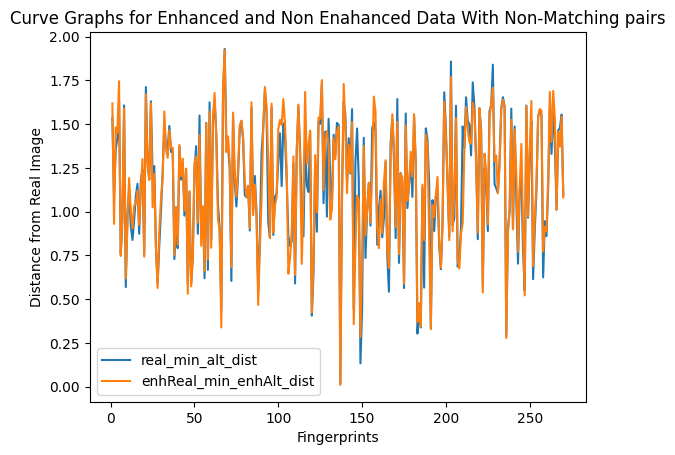

In [55]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_CR
#y2_data = real_min_enhAlt_dist
y3_data = enhReal_min_enhAlt_dist_CR

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Non Enahanced Data With Non-Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [56]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist_CR)
for dist1,dist2 in zip(real_min_alt_dist_CR,enhReal_min_enhAlt_dist_CR):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

151
119
postive_percent for non-matching pairs 55.925925925925924
negative_percent for non-matching pairs 44.074074074074076


In [49]:
len(enhReal_min_enhAlt_dist_Obl)

601

In [ ]:
enhReal_min_enhAlt_dist_Obl=enhReal_min_enhAlt_dist_Obl[2992:]

In [57]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist_Obl)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

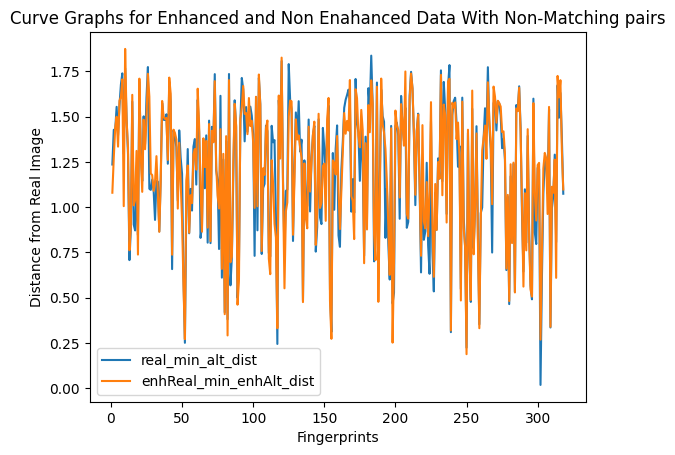

In [58]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_Obl
#y2_data = real_min_enhAlt_dist
y3_data = enhReal_min_enhAlt_dist_Obl

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Non Enahanced Data With Non-Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [59]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist_Obl)
for dist1,dist2 in zip(real_min_alt_dist_Obl,enhReal_min_enhAlt_dist_Obl):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

160
158
postive_percent for non-matching pairs 50.314465408805034
negative_percent for non-matching pairs 49.685534591194966


In [60]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist_Zcut)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

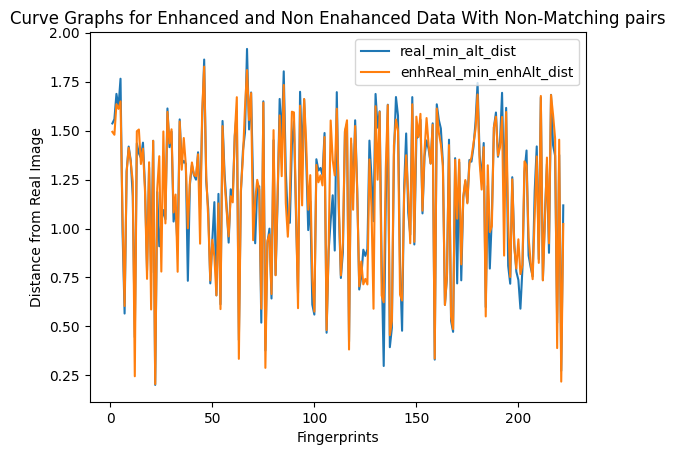

In [61]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_Zcut
#y2_data = real_min_enhAlt_dist
y3_data = enhReal_min_enhAlt_dist_Zcut

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Non Enahanced Data With Non-Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [62]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist_Zcut)
for dist1,dist2 in zip(real_min_alt_dist_Zcut,enhReal_min_enhAlt_dist_Zcut):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

104
118
postive_percent for non-matching pairs 46.846846846846844
negative_percent for non-matching pairs 53.153153153153156


In [75]:
TP=218
FN=48
TN=151
FP=119

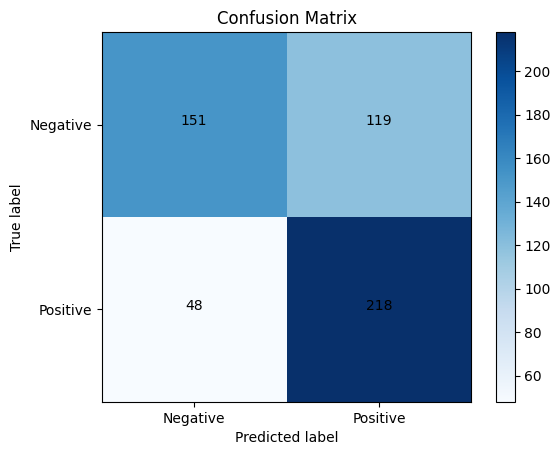

In [76]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define class labels
class_names = ['Negative', 'Positive']

# Create a heatmap
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Label the plot with the matrix values
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, f'{confusion_matrix[i, j]}', horizontalalignment="center", color="black" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [77]:
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [78]:
print("Accuracy:", accuracy*100)

Accuracy: 68.84328358208955


In [88]:
TP=148
FN=147
TN=160
FP=158

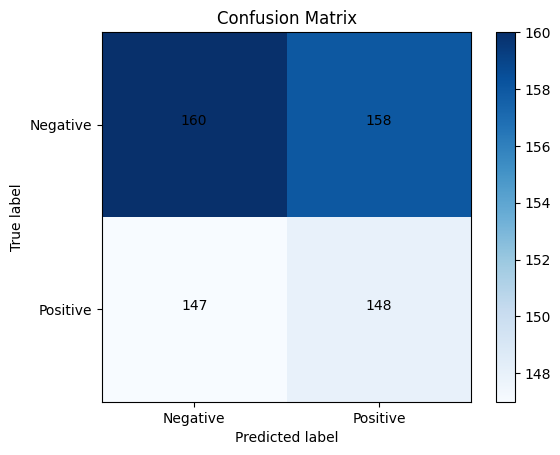

In [89]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define class labels
class_names = ['Negative', 'Positive']

# Create a heatmap
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Label the plot with the matrix values
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, f'{confusion_matrix[i, j]}', horizontalalignment="center", color="black" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [90]:
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [91]:
print("Accuracy:", accuracy*100)

Accuracy: 50.24469820554649


In [92]:
TP=149
FN=100
TN=104
FP=118

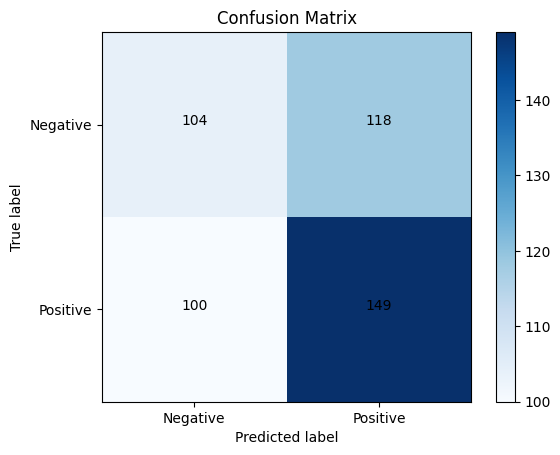

In [93]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define class labels
class_names = ['Negative', 'Positive']

# Create a heatmap
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Label the plot with the matrix values
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, f'{confusion_matrix[i, j]}', horizontalalignment="center", color="black" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [94]:
print("Accuracy:", accuracy*100)

Accuracy: 50.24469820554649
